# Modelling Investment in Renewable Energies, trial 2


## Library installation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import pickle
from tqdm import tqdm
import time
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.simplefilter('ignore')

#Models
from sklearn import metrics, naive_bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR, LinearSVC

from sklearn.neural_network import MLPRegressor, MLPClassifier


#Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, DictVectorizer
from scipy import sparse
from scipy.sparse import hstack
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

#Preprocessing and metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.impute import SimpleImputer


from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#Plotting

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/valentinereltien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valentinereltien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Uploading, cleaning & final engineering of datasets: 

Importing the dataset from prior notebooks, resulting from the merging of IRENA & WB sets. In addition, I import new WB features, as explained in the WB cleaning notebook. 

In [3]:
df2 = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/CSdf_3.csv')

In [4]:
add_df = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/Add_envt.csv')

In [5]:
add_df.columns

Index(['Country', 'Date', 'Forest area (% of land area)',
       'Total natural resources rents (% of GDP)'],
      dtype='object')

In [6]:
add_df.rename(columns = {'Forest area (% of land area)': 'ForestAr_pcLda',
                         'Total natural resources rents (% of GDP)' : 'NatRscrents_pcgdp'}, inplace=True)

In [7]:
add_df.iloc[:, 2:]

,ForestAr_pcLda,NatRscrents_pcgdp
0,2.06782464846981,NaN
1,2.06782464846981,NaN
2,2.06782464846981,1.11398250245278
3,2.06782464846981,0.7193573691149029
4,2.06782464846981,0.445267039525233
...,...,...
4349,38.7726514031601,8.070785541598019
4350,37.965102248125895,6.53393908674572
4351,37.1575556174874,6.999526794378071
4352,36.3500064624532,6.698086904182639


Performing a recheck of these additional features: 

In [8]:
add_df.NatRscrents_pcgdp.value_counts()

0.0                   336
3.07074969199511        2
6.10927440214148        2
3.33703988690494        2
13.4554660149447        2
                     ... 
7.94277993246101        1
7.51895193545068        1
5.6000908954022         1
1.7598681108699399      1
9.39622861327175        1
Name: NatRscrents_pcgdp, Length: 3786, dtype: int64

In [9]:
add_df.Date.value_counts()

2000    256
2008    256
2001    256
2005    256
2009    256
2013    256
2015    256
2002    256
2006    256
2010    256
2014    256
2004    256
2003    256
2007    256
2011    256
2012    256
2016    255
2019      1
2018      1
2017      1
Name: Date, dtype: int64

Filtering out unforeseenly inadequate date from the new features before merging them with the masterframe (df2): 

In [10]:
for x in range(2000, 2020):
    add_df = add_df[~ (add_df.NatRscrents_pcgdp == '{}-01-01T00:00:00.000000000'.format(x))]

In [11]:
add_df = add_df.astype({'ForestAr_pcLda': 'float',
          'NatRscrents_pcgdp' : 'float'})

In [12]:
add_df.dtypes

Country               object
Date                   int64
ForestAr_pcLda       float64
NatRscrents_pcgdp    float64
dtype: object

When trying to transform df2 in the below preprocessing, I discover it needs extra tweaking:

In [13]:
df2.Invested_USDM = df2.Invested_USDM.apply(lambda x: float(x.replace(',', '')))

I impute missing data with the columns' average value in order to preserve the information's integrity while still benefitting from the additional information incomplete rows' nonetheless provide:

Creating a copy for good practice & made final decision to drop the 'Source' column as to avoid cluttering.

In [14]:
X2 = df2.copy()
X2.drop(['Source'], axis=1, inplace=True)

Final check-up to optimize transformations: 

In [16]:
X2.isnull().sum()

Country                   0
Project                   0
Date                      0
Investor                  0
Technology                0
Asset Class               0
Invested_USDM             0
gdp_g_anpc                0
gni_g_anpc              665
AdjSav_Engdep_usd        28
AdjSav_CO2dmg_usd        46
AdjSav_Ptcldmg_pcGNI    113
Unemp_pcLF               62
AdjNetNatSv_usd         576
dtype: int64

I simplify the Date column into a single year instead of the whole formal notation. Indeed the year is the only changing element within the date observation

In [18]:
X2['Date'] = pd.to_datetime(X2.Date).dt.year

Merging of master frame and new WB features: 

In [20]:
X3 = pd.merge(X2, add_df, on = ['Country', 'Date'], how= 'left')
X3

,Country,Project,Date,Investor,Technology,Asset Class,Invested_USDM,gdp_g_anpc,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,AdjSav_Ptcldmg_pcGNI,Unemp_pcLF,AdjNetNatSv_usd,ForestAr_pcLda,NatRscrents_pcgdp
0,Afghanistan,afghanistan: emergency national solidarity pro...,2003,WBG,Multiple renewables*,Grant,22.6498,8.832278,NaN,9.581553e+05,1.998357e+07,NaN,11.604,NaN,2.067825,0.719357
1,Afghanistan,hydrocarbon resource survey — stage 1,2003,Others,Renewable Hydropower,Grant,0.2698,8.832278,NaN,9.581553e+05,1.998357e+07,NaN,11.604,NaN,2.067825,0.719357
2,Afghanistan,support to the electricity sector and dissemin...,2003,Others,Multiple renewables*,Grant,1.9594,8.832278,NaN,9.581553e+05,1.998357e+07,NaN,11.604,NaN,2.067825,0.719357
3,Afghanistan,afghanistan: emergency national solidarity pro...,2005,WBG,Multiple renewables*,Grant,5.9994,11.229715,NaN,1.472570e+06,2.495481e+07,NaN,11.429,NaN,2.067825,0.384404
4,Afghanistan,development worker,2005,Others,Multiple renewables*,Grant,0.1376,11.229715,NaN,1.472570e+06,2.495481e+07,NaN,11.429,NaN,2.067825,0.384404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,Zimbabwe,tc aggregated activities,2016,JICA,Multiple renewables*,Grant,0.0078,0.755869,2.468722,1.347917e+07,3.535575e+08,0.895091,5.253,-2.929812e+09,35.542457,6.737748
7174,Zimbabwe,yali - rugare global solar private limited,2016,Others,Solar energy,Grant,0.0100,0.755869,2.468722,1.347917e+07,3.535575e+08,0.895091,5.253,-2.929812e+09,35.542457,6.737748
7175,Zimbabwe,aecf 2017-22 renewable energy and adaptation t...,2017,Others,Multiple renewables*,Grant,5.7101,4.704035,4.744133,3.132278e+07,3.730322e+08,0.845351,5.168,-3.675947e+09,NaN,NaN
7176,Zimbabwe,construction and equipment for education centr...,2017,Others,Solar energy,Grant,0.0051,4.704035,4.744133,3.132278e+07,3.730322e+08,0.845351,5.168,-3.675947e+09,NaN,NaN


I impute missing data with the columns' average value in order to preserve the information's integrity while still benefitting from the additional information incomplete rows' nonetheless provide.

In [22]:
X3.fillna(X3.mean())

,Country,Project,Date,Investor,Technology,Asset Class,Invested_USDM,gdp_g_anpc,gni_g_anpc,AdjSav_Engdep_usd,AdjSav_CO2dmg_usd,AdjSav_Ptcldmg_pcGNI,Unemp_pcLF,AdjNetNatSv_usd,ForestAr_pcLda,NatRscrents_pcgdp
0,Afghanistan,afghanistan: emergency national solidarity pro...,2003,WBG,Multiple renewables*,Grant,22.6498,8.832278,4.222071,9.581553e+05,1.998357e+07,0.577870,11.604,1.132966e+11,2.067825,0.719357
1,Afghanistan,hydrocarbon resource survey — stage 1,2003,Others,Renewable Hydropower,Grant,0.2698,8.832278,4.222071,9.581553e+05,1.998357e+07,0.577870,11.604,1.132966e+11,2.067825,0.719357
2,Afghanistan,support to the electricity sector and dissemin...,2003,Others,Multiple renewables*,Grant,1.9594,8.832278,4.222071,9.581553e+05,1.998357e+07,0.577870,11.604,1.132966e+11,2.067825,0.719357
3,Afghanistan,afghanistan: emergency national solidarity pro...,2005,WBG,Multiple renewables*,Grant,5.9994,11.229715,4.222071,1.472570e+06,2.495481e+07,0.577870,11.429,1.132966e+11,2.067825,0.384404
4,Afghanistan,development worker,2005,Others,Multiple renewables*,Grant,0.1376,11.229715,4.222071,1.472570e+06,2.495481e+07,0.577870,11.429,1.132966e+11,2.067825,0.384404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,Zimbabwe,tc aggregated activities,2016,JICA,Multiple renewables*,Grant,0.0078,0.755869,2.468722,1.347917e+07,3.535575e+08,0.895091,5.253,-2.929812e+09,35.542457,6.737748
7174,Zimbabwe,yali - rugare global solar private limited,2016,Others,Solar energy,Grant,0.0100,0.755869,2.468722,1.347917e+07,3.535575e+08,0.895091,5.253,-2.929812e+09,35.542457,6.737748
7175,Zimbabwe,aecf 2017-22 renewable energy and adaptation t...,2017,Others,Multiple renewables*,Grant,5.7101,4.704035,4.744133,3.132278e+07,3.730322e+08,0.845351,5.168,-3.675947e+09,31.594789,5.980138
7176,Zimbabwe,construction and equipment for education centr...,2017,Others,Solar energy,Grant,0.0051,4.704035,4.744133,3.132278e+07,3.730322e+08,0.845351,5.168,-3.675947e+09,31.594789,5.980138


In [23]:
for ind, col in enumerate(X3.loc[:,'gni_g_anpc':].columns):
    #print(ind, col)
    X3[col] = X3[col].fillna(X3[col].mean())

After the above addition, I decide to add yet more features (cf Modelling trial 1, section 2.5 for engineering process) to improve the model's potential. Merging process below: 

In [24]:
add_df2 = pd.read_csv('/Users/valentinereltien/Desktop/IRENA/Engy_addfts.csv')

In [25]:
add_df2.isnull().sum()

Country     0
Date        0
gdp_fluc    0
gni_fluc    0
NS_fluc     0
dtype: int64

In [26]:
X4 = X3.merge(add_df2, on = ['Country', 'Date'], how = 'left')

Final check of the model's readiness: 

In [28]:
X4.isnull().sum()

Country                 0
Project                 0
Date                    0
Investor                0
Technology              0
Asset Class             0
Invested_USDM           0
gdp_g_anpc              0
gni_g_anpc              0
AdjSav_Engdep_usd       0
AdjSav_CO2dmg_usd       0
AdjSav_Ptcldmg_pcGNI    0
Unemp_pcLF              0
AdjNetNatSv_usd         0
ForestAr_pcLda          0
NatRscrents_pcgdp       0
gdp_fluc                0
gni_fluc                0
NS_fluc                 0
dtype: int64

Plot the heatmap to visualize new features' correlations: 

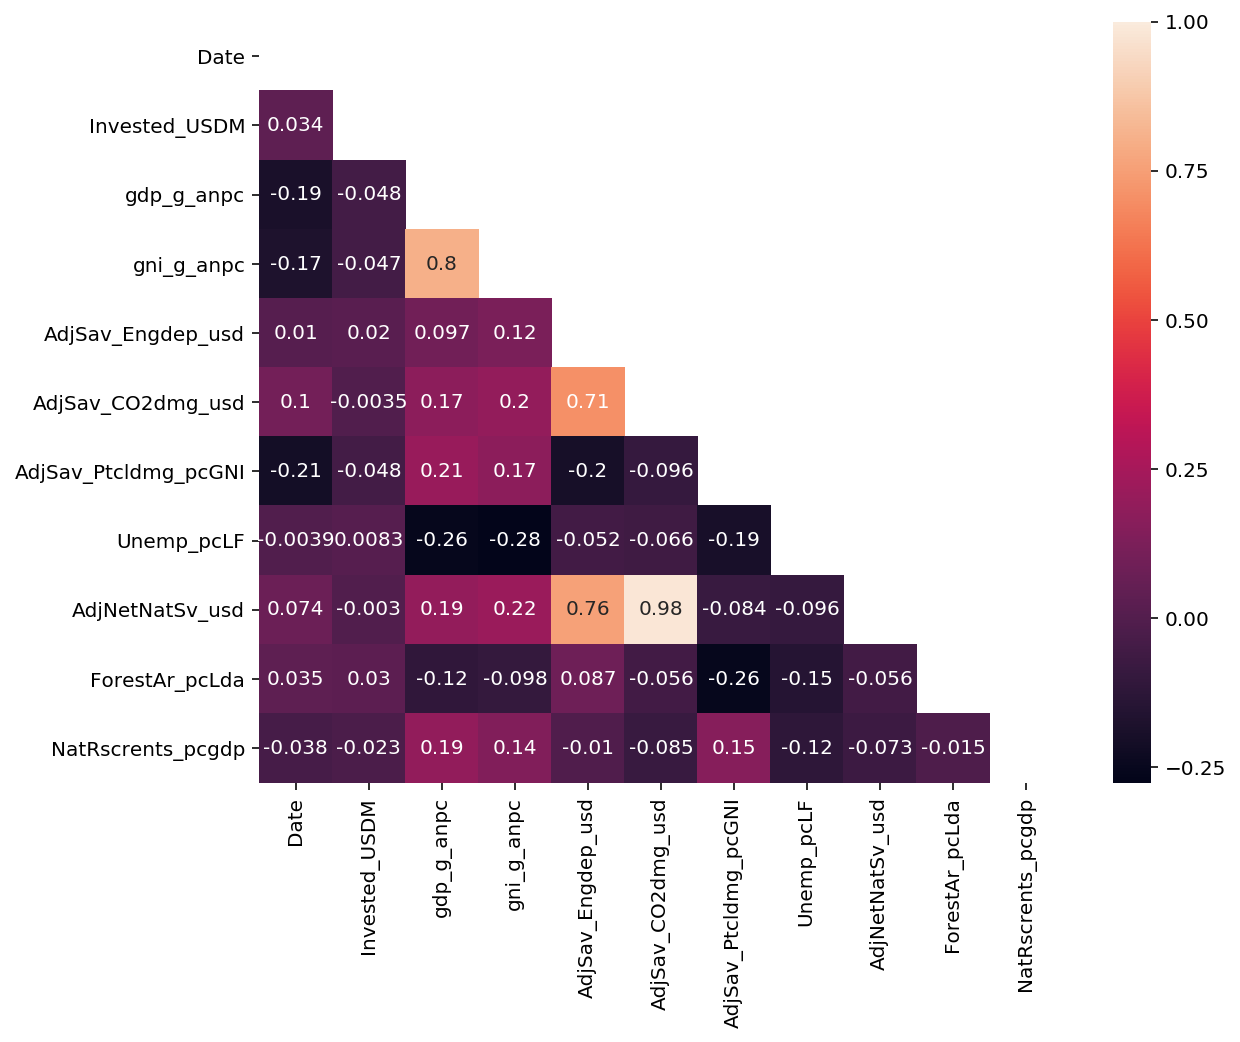

In [238]:
fig, ax = plt.subplots(figsize=(9, 7))

mask = np.zeros_like(X4.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X4.corr(), mask=mask, annot=True, ax=ax)

plt.xticks(rotation=45)
plt.show()

fig.savefig('Eng_correlations3.pdf', bbox_inches='tight')

## Train_test Splitting:

Creating train & test set based on year of 2015 to split data in near 80/20 fashion: 2001:2015 - 2015:2017. Value_counts reveal a greater concentration of data was collected since 2015 justifying the split

In [35]:
X_train = X4[X4.Date < 2015]

In [36]:
X_test = X4[X4.Date >= 2015]

Extract target to get a sense of investments' distributions. Quartiles explained below. 

In [31]:
y = X4.Invested_USDM

In [33]:
print("Q1 divide (millions of dollars invested):", np.percentile(y, 25))
print("Q2 divide (millions of dollars invested):", np.percentile(y, 50))
print("Q3 divide (millions of dollars invested):", np.percentile(y, 75))

Q1 divide (millions of dollars invested): 0.047025000000000004
Q2 divide (millions of dollars invested): 0.5441499999999999
Q3 divide (millions of dollars invested): 15.0


Creating 2 different target values to experiment with predicting both a continuous & categorical variable using regressors on the one hand and classification models on the other. 


Regression target: 

In [37]:
yr_train = X_train.pop('Invested_USDM')

In [38]:
yr_test = X_test.pop('Invested_USDM')

Regression baseline, in millions $

In [243]:
yr_train.mean()

25.918922987067255

The classification target is defined by the four possible quartiles of investment received by each project: 

    0 : project belongs to the lowest quartile, Q1, ie 25% of projects having received smallest investment

    1 : project belongs to the second quartile, Q2, ie 25% of projects having received investment with a maximum of the median yet more than Q1

    2 : project belongs to the third quartile, Q3, ie 25% of projects having received the median investment quantity as a minimum

    3: project belongs to the fourth and highest quartile, Q4, ie 25 % projects having received the greatest investment quantity

Classification target

In [40]:
yc_train = yr_train.apply(lambda x: '0' if x <= np.percentile(yr_train, 25) else 
         ('1' if x <= yr_train.median() else ('2' if x <= np.percentile(yr_train, 75) else '3')))

In [41]:
yc_test = yr_test.apply(lambda x: '0' if x <= np.percentile(yr_test, 25) else 
         ('1' if x <= yr_test.median() else ('2' if x <= np.percentile(yr_test, 75) else '3')))

Classification baseline: 

In [246]:
yc_train.value_counts(normalize=True)

3    0.250104
0    0.250104
1    0.249896
2    0.249896
Name: Invested_USDM, dtype: float64

Converting sets in an attempt to troubleshoot the error which arose while performing NLP on the 'Project' column. 
("Vectorizer can't take arrays") 

In [247]:
yc_test = pd.Series(yc_test)
yc_train = pd.Series(yc_train)

In [248]:
yc_train = yc_train.astype(int)
yc_test = yc_test.astype(int)

In [249]:
yr_test = pd.Series(yr_test)
yr_train = pd.Series(yr_train)

## Column Transformation

Prepping the "Project" description column to perform NLP and extract insights from its text. Before stemming its tokens for vectorization, I must first join all words from each project's text into a list to iterate over.

In [54]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

words = []
for x in X_train.Project: 
    words.append(x.split(' '))
    
list_words = [item for sublist in words for item in sublist]

stemmed_text = []
for token in list_words:
     stemmed_text.append(ps.stem(token)) 
stemmed_text

lemma_text = []
for token in list_words:
     lemma_text.append(lemmatizer.lemmatize(token))


I add different languages to the stopwords (corresponding to major projects' origin: namely North & South America and Europe) in addition to terms explicitly pertaining to Renewable Energies, filtering these out for more insight. After a first trial, I also decide to block out digits as done by 'num_list'. This required I run a first very basic column vectorization as performed in the first cell below:

In [61]:
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1))
X_all = tfidf.fit_transform(lemma_text)
columns = tfidf.get_feature_names()

In [62]:
numlist = [word for word in columns if re.match('\d+', word)]
stop = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + stopwords.words('portuguese')
stop += ['tc', 'ii', 'de', 'ab', 'abc', 'cc', 'énergie', 'energy', 'energies', 'project', 'fk', 'renewable', 'renouvelable',
         'renewables', 'power']
stop += numlist

I proceed with the set up of the Column Transformer. This pipeline of pipelines enables the simultaneous transformation of all datasets' different data types. I prepare 3 pipelines here referring to numerical, categorical and linguistic features to perform Standard Scaling, OneHotEncoding and TFIDF respectively.

In [65]:
numeric_features = ['gdp_g_anpc', 'gni_g_anpc', 'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd',
       'AdjSav_Ptcldmg_pcGNI', 'Unemp_pcLF', 'AdjNetNatSv_usd', 'ForestAr_pcLda', 'NatRscrents_pcgdp']
numeric_transformer = Pipeline(steps=[
   ('scaler', StandardScaler())])

categorical_features = ['Country', 'Date', 'Investor', 'Technology', 'Asset Class', 'gdp_fluc', 'gni_fluc',
       'NS_fluc' ]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

nlp_features = 'Project'

clnlp_transformer = Pipeline(steps=[#These features come from the below param_grid
     ('Tfidf', TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode',
                        max_df = 0.75, max_features= 500, min_df= 0.0025, ngram_range = (1, 2)))])


clf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('nlp', clnlp_transformer, nlp_features)])


To avoid rerunning the parameter grid, I inserted its best parameters in the above pipeline. However, for the sake of thoroughness, below is the explicit gridsearch it results from. Cf section 1.5 for more details. 

In [66]:
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class= 'ovr') 

pipe = Pipeline(steps=[('preprocessor', clf_preprocessor),
                      ('classifier', model)])

param_grid = {
    
    'preprocessor__nlp__Tfidf__max_df' : [0.75, 0.8, 0.9],
    'preprocessor__nlp__Tfidf__max_features': [60, 100, 200, 500, 1000, 10000, 50000],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.005, 0.01, 0.05],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2), (2, 3)] }

        
grid_search = GridSearchCV(pipe, param_grid, cv=10, iid=False, verbose=1)
grid_search.fit(X_train, yc_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, yc_test)))

print('Tfdidf params for best score: ', grid_search.best_params_)

print("Test score:", grid_search.score(X_test, yc_test))


Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2520 out of 2520 | elapsed: 52.0min finished


best logistic regression from grid search: 0.536
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.75, 'preprocessor__nlp__Tfidf__max_features': 500, 'preprocessor__nlp__Tfidf__min_df': 0.0025, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.5360738255033557


In [137]:
X_test.shape, X_train.shape, yc_train.shape, yc_test.shape

((2384, 13), (4794, 15), (4794,), (2384,))

Crucial final step: transforming train & test splits by target type to integrate the Column Transformations

In [318]:
train_clX = clf_preprocessor.fit_transform(X_train)
test_clX = clf_preprocessor.transform(X_test)

In an attempt to improve my model, I try rescaling the preprocessed data for the sake of harmonization (notably the Hot Encoded ones). I choose with_mean = False so as that it ignores the 1s & 0s resulting from encoding and does not confuse itself with these categorical inputs. 

In [319]:
scaler = StandardScaler(with_mean=False)
train_clX = scaler.fit_transform(train_clX)
test_clX = scaler.transform(test_clX)

Anticipating section 2.2's study of features importances, I manually extract features which result from TFIDF and OneHotEncoding and store them in an 'all_features' list

In [316]:
cl_text = clf_tvec.fit_transform(X_train.Project)

Cltext_df = pd.DataFrame(cl_text.todense(),
                  columns=clf_tvec.get_feature_names())
Cltext_df.transpose().sort_values(0, ascending=False).transpose()

cl_nlpfeatures = clf_tvec.get_feature_names()

In [320]:
onehot = OneHotEncoder(handle_unknown='ignore')

hotties = onehot.fit_transform(X_train[categorical_features])

hot_df = pd.DataFrame(hotties.todense(),
                  columns=onehot.get_feature_names())

hot_df.transpose().sort_values(0, ascending=False).transpose()

hot_features = onehot.get_feature_names()

In [321]:
len(cl_nlpfeatures) + len(hot_features) + len(numeric_features)

592

In [307]:
numeric_features = ['gdp_g_anpc', 'gni_g_anpc', 'AdjSav_Engdep_usd', 'AdjSav_CO2dmg_usd','AdjSav_Ptcldmg_pcGNI',
                    'Unemp_pcLF', 'AdjNetNatSv_usd', 'ForestAr_pcLda', 'NatRscrents_pcgdp']

len(numeric_features)

9

In [261]:
all_features = list(hot_features) + list(cl_nlpfeatures) + numeric_features

## Trial TFIDF quest: 

Gridsearching through multiple TFIDF features, in a quest for the one that would best perform on an initial Logistic Regression. I boosted the two best ones to the top of the list. Can scroll down to discover which features were played with:

In [303]:
#Trying another more fitted GS: 

param_grid2 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.7, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [200, 300, 400, 500, 600],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0015, 0.0025, 0.005],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,2)]}

grid_search = GridSearchCV(pipe, param_grid2, cv=10, iid=False, verbose=1)
grid_search.fit(X_train, yc_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, yc_test)))

print('Tfdidf params for best score: ', grid_search.best_params_)

print("Test score:", grid_search.score(X_test, yc_test))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  4.3min finished


best logistic regression from grid search: 0.549
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.7, 'preprocessor__nlp__Tfidf__max_features': 600, 'preprocessor__nlp__Tfidf__min_df': 0.001, 'preprocessor__nlp__Tfidf__ngram_range': (1, 2)}
Test score: 0.549496644295302


In [343]:
param_grid8 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.001, 0.1],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    #'preprocessor__nlp__Tfidf__min_df': [0.0009, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search6 = GridSearchCV(reg_pipe, param_grid8, cv=10, iid=False, verbose=1)
Rgrid_search6.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search6.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search6.best_params_)

print("Test score:", Rgrid_search6.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


best linear regression from grid search: 0.240
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.001, 'preprocessor__nlp__Tfidf__max_features': 20, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.23954067485018338


In [325]:
#Testing tfidf for regression: 

lr = LinearRegression() 
# RandomForestClassifier,
# AdaBoost

reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lr)])

param_grid2 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.7, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [200, 300, 400, 500, 600],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0015, 0.0025, 0.005],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,2)]}

Rgrid_search = GridSearchCV(reg_pipe, param_grid2, cv=10, iid=False, verbose=1)
Rgrid_search.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search.best_params_)

print("Test score:", Rgrid_search.score(X_test, yr_test))

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  6.7min finished


best logistic regression from grid search: 0.180
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__max_features': 200, 'preprocessor__nlp__Tfidf__min_df': 0.005, 'preprocessor__nlp__Tfidf__ngram_range': (1, 2)}
Test score: 0.18021852345003697


In [327]:
lr = LinearRegression() 
# RandomForestClassifier,
# AdaBoost

reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lr)])

param_grid4 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.5, 0.6, 0.75],
    'preprocessor__nlp__Tfidf__max_features': [60, 100, 200, 300],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.003, 0.005, 0.01],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search2 = GridSearchCV(reg_pipe, param_grid4, cv=10, iid=False, verbose=1)
Rgrid_search2.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search2.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search2.best_params_)

print("Test score:", Rgrid_search2.score(X_test, yr_test))

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  5.2min finished


best linear regression from grid search: 0.201
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__max_features': 60, 'preprocessor__nlp__Tfidf__min_df': 0.01, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.20118711408927825


In [329]:
param_grid5 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    #'preprocessor__nlp__Tfidf__max_df' : [None, 0.5, 0.55],
    'preprocessor__nlp__Tfidf__max_features': [40, 50, 60, 70],
    'preprocessor__nlp__Tfidf__min_df': [0.0025, 0.003, 0.005, 0.01, 0.02],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1), (1,2)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search3 = GridSearchCV(reg_pipe, param_grid5, cv=10, iid=False, verbose=1)
Rgrid_search3.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search3.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search3.best_params_)

print("Test score:", Rgrid_search3.score(X_test, yr_test))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished


best linear regression from grid search: 0.207
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_features': 40, 'preprocessor__nlp__Tfidf__min_df': 0.003, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.20713953032970644


In [336]:
param_grid6 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    #'preprocessor__nlp__Tfidf__max_df' : [None, 0.5, 0.55],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    'preprocessor__nlp__Tfidf__min_df': [0.001, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search4 = GridSearchCV(reg_pipe, param_grid6, cv=10, iid=False, verbose=1)
Rgrid_search4.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search4.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search4.best_params_)

print("Test score:", Rgrid_search4.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


best linear regression from grid search: 0.229
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_features': 10, 'preprocessor__nlp__Tfidf__min_df': 0.001, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.2292510653546006


In [344]:
#It seems score stalls whether or not max/min_df are kept or  not, therefore: 

reg_tfidf = TfidfVectorizer(stop_words = stop, use_idf=True, smooth_idf=True, strip_accents ='unicode', 
                            max_features = 20, max_df = 0.001, ngram_range = (1, 1))

In [335]:
#Try removing min_df too? 
param_grid9 = {
      #'preprocessor__num__scaler__strategy': ['mean', 'median'],
    'preprocessor__nlp__Tfidf__max_df' : [0.001, 0.1],
    'preprocessor__nlp__Tfidf__max_features': [10, 20, 30, 40, 50],
    'preprocessor__nlp__Tfidf__min_df': [0.0009, 0.0025, 0.003, 0.004],
    'preprocessor__nlp__Tfidf__ngram_range':[(1,1)],
#     'classifier__C': [0.1, 1.0, 10, 100],
#     'classifier__solver': ['liblinear', 'lbfgs']
#Removed all None from max/mindf & features
}

Rgrid_search4 = GridSearchCV(reg_pipe, param_grid7, cv=10, iid=False, verbose=1)
Rgrid_search4.fit(X_train, yr_train)

print(("best linear regression from grid search: %.3f"
       % Rgrid_search4.score(X_test, yr_test)))

print('Tfdidf params for best score: ', Rgrid_search4.best_params_)

print("Test score:", Rgrid_search4.score(X_test, yr_test))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   59.8s finished


best linear regression from grid search: 0.215
Tfdidf params for best score:  {'preprocessor__nlp__Tfidf__max_df': 0.5, 'preprocessor__nlp__Tfidf__min_df': 0.02, 'preprocessor__nlp__Tfidf__ngram_range': (1, 1)}
Test score: 0.21501613548377707


What's the impact on investment from Covid: 
Look at differences of GDP from year/year: 
For e country's GDP:how much does it change fm yr/yr: increase vs decrease
How does that impact received investment? M+ v l- 
Project : 
What's expected GDP for this year: estimate of dtpt as additional obsvtn in dataset: 
For 2019/following year. 

 Model could assess whether GDP is x % lower/upper than last year : 
     model predicts impact> investment received by country
Fit on features (U r, GDP, GNI, Adjusted)
Clustering : b> tiers of total investment
Leave residuals
Pipeline & GS all Regression models
Keep tabs on narrative, on critical insight/commentary & Metadata
Add an extra column of GDP & GNI growth direction
Use this as column to help predict investment received in future

Using LogReg: when split Train/test: Use 

Method/pattern will have changed btw early 2000s/2017 
*^* maybe G+ to try to split train/test chronoligcally 
Keep year column 

To-do: Reload Adjusted Savings as USD vs %
Recreate X with dummies & new vectorized column for project
Explore PCAs & Clusters 
Start exploring models? 

TEchnically if model works, if a project is brought to me, then I could help them inform of how much funds they
might receive
Could help guide them in the right direction.

Next: train/test chronologically? B> on dates? 
Rerun this or 

## Searching for the Optimal Classification Model: 

In an attempt to make the process as thorough and autonomous as possible, I decided to create batches of models and parameter grids to run through simultaneously. Note I decided to leave DecisionTrees out in favor of Ensemble Methods. Also separate classifiers and regressors as they relate to different datasets.

In [322]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(),
    #DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    GaussianNB(), 
    BernoulliNB(), 
    svm.SVC(probability = True)
    ]

regressors = [ElasticNet(max_iter = 100000),
             #DecisionTreeRegressor(), 
             RandomForestRegressor(), 
             AdaBoostRegressor(),
             GradientBoostingRegressor(),
            svm.SVR()
             ]


In [323]:
knn_params= {
    'n_neighbors' : [2, 3, 4, 5, 6],
    'weights' : ['distance', 'uniform']}

logreg_params = {'C': np.logspace(-5, 5, 15),
'penalty': ['l1', 'l2'],
'fit_intercept': [True, False]}

rf_params = {'bootstrap': [True],
'max_depth': [80, 90, 100, 110], 
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [1000]}


ada_params = {'n_estimators': [50, 100, 200, 500],
              'base_estimator' : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3),
                                  DecisionTreeClassifier(max_depth=4)]}

gb_params = {'n_estimators': [200, 500, 1000],
'learning_rate': [0.02, 0.05],
'max_depth': [1, 2],
'min_samples_leaf': [5,10],
'min_samples_split': [5,10]} 

clf_grids = [knn_params, logreg_params, rf_params, ada_params, gb_params] #dt_params

enet_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
'l1_ratio': np.linspace(0.0001, 1.0, 20)}


The following list comprehensions allow me to loop through each model/grid pairs.

In [324]:
model_gs = zip(classifiers[:-3], clf_grids)

In [325]:
model_grids = [(i, m) for i, m in model_gs]

The looping begins! I initialize the overarching 'clf' dictionary which will collect the best model resulting from each loop's gridsearch. This will then enable me to efficiently retrieve the best performing models.

In [328]:
clf = {}
for model, grid in tqdm(model_grids):
    
    temp_clf = {}
    gs = GridSearchCV(model, param_grid = grid, cv=5, n_jobs= 1, verbose=1, scoring = 'accuracy')
    gs.fit(train_clX, yc_train)

    gs_best = gs.best_estimator_
    
   #gs_best.fit(train_X, yc_train)
    gs_optCV = gs.best_score_ 
    gs_CV = cross_val_score(gs_best, train_clX, yc_train, cv = 5).mean()
    test_score = gs.score(test_clX, yc_test)
    gs_params = gs.best_params_

    temp_clf['Model'] = gs_best
    temp_clf['Mean CV'] = gs_CV
    temp_clf['Test_score'] = test_score

    clf[str(model)] = temp_clf 

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.7s finished
 20%|██        | 1/5 [00:16<01:07, 16.91s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.9min finished
 40%|████      | 2/5 [07:11<06:48, 136.22s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 25.5min finished
 60%|██████    | 3/5 [33:13<18:47, 563.87s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.8min finished
 80%|████████  | 4/5 [38:53<08:16, 496.85s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 76.0min finished
100%|██████████| 5/5 [1:56:13<00:00, 1394.74s/it]


Exploring SVC's results separately to optimize time. Indeed, gridsearching SVCs is a lengthy process which I preferred to do separately. I proceed similarly than above: creating a dictionary with the loop's results which I then add to the clf master dictionary.

In [305]:
# temp_svc = {}

# svc = svm.SVC(probability=True, verbose= 1)

# svc_grid = {'gamma' : np.logspace(-5, 2, 10),
#              'C' : np.logspace(-3, 2, 10), 
#              'kernel' : ['rbf', 'sigmoid', 'linear', 'poly']}

# svc_gs = GridSearchCV(svc, svc_grid, cv=3,
#                     scoring='accuracy', verbose=1, n_jobs=2)
# svc_gs.fit(train_clX, yc_train)
# # svc_best = svc.best_estimator_
# gs_optCV = svc_gs.best_score_ 
# gs_CV = cross_val_score(svc, train_clX, yc_train, cv = 5).mean()
# test_score = svc_gs.score(test_clX, yc_test)
# # gs_params = gs.best_params_


# temp_svc['Model'] = svc
# temp_svc['Mean CV'] = gs_CV
# temp_svc['Test_score'] = test_score

# #clf['SVC'] = temp_svc

After letting the above search run for nearly 48hours, I decided to interrupt the kernel and narrow the GS down to the previous notebooks' scale:

In [331]:
temp_svc = {}

svc = svm.SVC(probability=True, verbose= 1)

svc_grid = {'gamma' : np.logspace(-6, -4, 4),
             'C' : np.logspace(0, 1, 4),
             'kernel' : ['rbf', 'linear']}

svc_gs = GridSearchCV(svc, svc_grid, cv=3,
                    scoring='accuracy', verbose=1, n_jobs=2)
svc_gs.fit(train_clX, yc_train)
# svc_best = svc.best_estimator_
gs_optCV = svc_gs.best_score_ 
gs_CV = cross_val_score(svc, train_clX, yc_train, cv = 5).mean()
test_score = svc_gs.score(test_clX, yc_test)
# gs_params = gs.best_params_


temp_svc['Model'] = svc
temp_svc['Mean CV'] = gs_CV
temp_svc['Test_score'] = test_score

#clf['SVC'] = temp_svc

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 56.8min
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed: 1120.7min finished


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [332]:
clf['SVC'] = temp_svc

Exploring a Neural Network separately for the same reason as above. The same 'temporary dictionary to master dictionary' process as SVC is followed here too. 

In [334]:
temp_nnet = {}

nnet = MLPClassifier()

nn_grid = {'solver' : ['adam','lbfgs','sgd'],
            'alpha' : [10**(5)],
            'hidden_layer_sizes' : [1, 2, 4],
            'activation' : ['relu', 'tanh'],
           #'learning rate' : [0.1, 0.001, 0.01],
            'random_state' : [1],
            'batch_size' : [5, 10, 20, 50, 100],
            'max_iter' : [1000] }

nngs = GridSearchCV(nnet, nn_grid, cv = 3, verbose=1, n_jobs =1)
nngs.fit(train_clX, yc_train)
nngs_best = nngs.best_estimator_
nngs_CV = cross_val_score(nngs_best, train_clX, yc_train, cv = 5).mean()
test_score = nngs_best.score(test_clX, yc_test)

temp_nnet['Model'] = nngs_best
temp_nnet['Mean CV'] = nngs_CV
temp_nnet['Test_score'] = test_score

print(test_score)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 1093.1min finished


0.25


In [338]:
temp_nnet

{'Model': MLPClassifier(activation='relu', alpha=100000, batch_size=5, beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=1, learning_rate='constant',
               learning_rate_init=0.001, max_iter=1000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=1, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 'Mean CV': 0.2498956158663883,
 'Test_score': 0.25}

In [339]:
clf['NNet'] = temp_nnet

Finally, running Naive Bayes models. They're also done separately as they don't admit of gridsearches and the sparse matrix dataset must be unravelled for it to run. Results are also added to the clf dictionary.

In [336]:
for classifier in tqdm(classifiers[-3:-1]):
    temp_dict = {}

    model = classifier
    dense_train = train_clX.toarray()
    dense_test = test_clX.toarray()
    model.fit(dense_train, yc_train)
    meancv = cross_val_score(model, dense_train, yc_train, cv=5).mean()
    test_score = model.score(dense_test, yc_test)

    temp_dict['Model'] = model
    temp_dict['Mean CV'] = meancv
    temp_dict['Test_score'] = test_score

    clf[str(classifier)] = temp_dict
        

100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


For usability, I transform the dictionary into a dataframe:

In [342]:
results_clf = pd.DataFrame(clf)

In [343]:
results_clf

,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=5, p=2,\n weights='uniform')","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators='warn',\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,\n n_estimators=50, random_state=None)","GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0,\n warm_start=False)",SVC,NNet,"GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)"
Model,"KNeighborsClassifier(algorithm='auto', leaf_si...","LogisticRegression(C=0.0002682695795279727, cl...","(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri...",([DecisionTreeRegressor(criterion='friedman_ms...,"SVC(C=1.0, cache_size=200, class_weight=None, ...","MLPClassifier(activation='relu', alpha=100000,...","GaussianNB(priors=None, var_smoothing=1e-09)","BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
Mean CV,0.415318,0.531892,0.517301,0.44118,0.527914,0.501873,0.249896,0.342552,0.513747
Test_score,0.417785,0.52349,0.528523,0.486577,0.51594,0.519715,0.25,0.424916,0.518037


I simplify column names and transpose the dataframe for better readability:

In [344]:
cols_1 = results_clf.columns
cols_2 = ['KNN', 'LogReg', 'RandomForest', 'AdaBoost', 'GBoost', 'SVC', 'NNet', 'G_NB', 'B_NB']

results_clf.rename(
    columns={i:j for i,j in zip(cols_1, cols_2)}, inplace=True)

In [345]:
clf_results = results_clf.T
clf_results.columns

Index(['Model', 'Mean CV', 'Test_score'], dtype='object')

In [346]:
clf_results.rename(columns = {'Model': 'Params', 'Mean CV': 'Mean_CV'}, inplace=True)

In [347]:
clf_results

,Params,Mean_CV,Test_score
KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.415318,0.417785
LogReg,"LogisticRegression(C=0.0002682695795279727, cl...",0.531892,0.52349
RandomForest,"(DecisionTreeClassifier(class_weight=None, cri...",0.517301,0.528523
AdaBoost,"(DecisionTreeClassifier(class_weight=None, cri...",0.44118,0.486577
GBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.527914,0.51594
SVC,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.501873,0.519715
NNet,"MLPClassifier(activation='relu', alpha=100000,...",0.249896,0.25
G_NB,"GaussianNB(priors=None, var_smoothing=1e-09)",0.342552,0.424916
B_NB,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.513747,0.518037


Will retain top 3 models for further investigation, collected in the top_clf dataframe. This is extracted by sorting the clf dataframe and keeping the top 3. Interestingly, models and scores have changed from the 1st trial. Let's study them further in the next section. 

In [348]:
clf_results.sort_values(by = 'Test_score', ascending=False, inplace=True)

In [349]:
clf_results

,Params,Mean_CV,Test_score
RandomForest,"(DecisionTreeClassifier(class_weight=None, cri...",0.517301,0.528523
LogReg,"LogisticRegression(C=0.0002682695795279727, cl...",0.531892,0.52349
SVC,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.501873,0.519715
B_NB,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.513747,0.518037
GBoost,([DecisionTreeRegressor(criterion='friedman_ms...,0.527914,0.51594
AdaBoost,"(DecisionTreeClassifier(class_weight=None, cri...",0.44118,0.486577
G_NB,"GaussianNB(priors=None, var_smoothing=1e-09)",0.342552,0.424916
KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.415318,0.417785
NNet,"MLPClassifier(activation='relu', alpha=100000,...",0.249896,0.25


In [350]:
top_clf = clf_results[:3]

In [351]:
top_clf.Params[0]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [239]:
opt_lg2 = LogisticRegression(C=0.19306977288832497, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluating three best classification models: 

## Classification Report & Confusion Matrices : 

Looping through all best models to visualize their classification report on confusion matrix to gain insight into their alternative scores (namely precision & recall).

RandomForest's Classification Report: 
               precision    recall  f1-score   support

           0     0.6085    0.5503    0.5780       596
           1     0.4617    0.4547    0.4582       596
           2     0.3445    0.1376    0.1966       596
           3     0.5598    0.9581    0.7067       596

    accuracy                         0.5252      2384
   macro avg     0.4936    0.5252    0.4849      2384
weighted avg     0.4936    0.5252    0.4849      2384

RandomForest's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


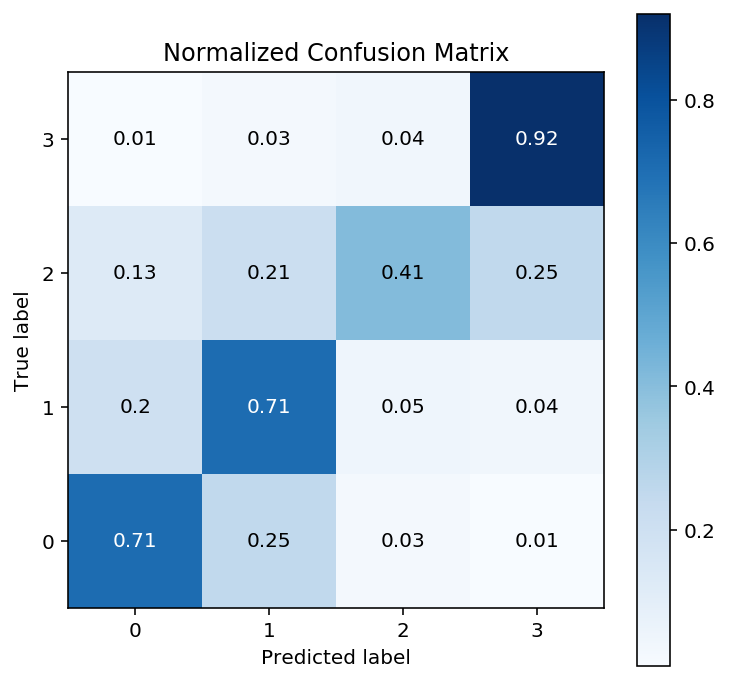

LogReg's Classification Report: 
               precision    recall  f1-score   support

           0     0.5808    0.5369    0.5580       596
           1     0.4596    0.4295    0.4441       596
           2     0.3729    0.1846    0.2469       596
           3     0.5729    0.9430    0.7127       596

    accuracy                         0.5235      2384
   macro avg     0.4965    0.5235    0.4904      2384
weighted avg     0.4965    0.5235    0.4904      2384

LogReg's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


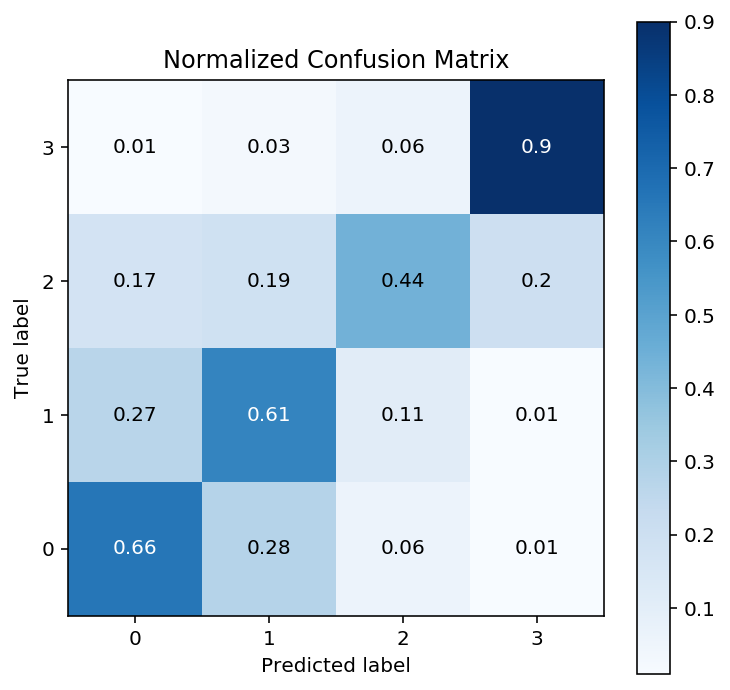

[LibSVM]SVC's Classification Report: 
               precision    recall  f1-score   support

           0     0.5869    0.5268    0.5553       596
           1     0.4497    0.3826    0.4134       596
           2     0.3341    0.2450    0.2827       596
           3     0.5901    0.8960    0.7115       596

    accuracy                         0.5126      2384
   macro avg     0.4902    0.5126    0.4907      2384
weighted avg     0.4902    0.5126    0.4907      2384

SVC's Confusion Matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


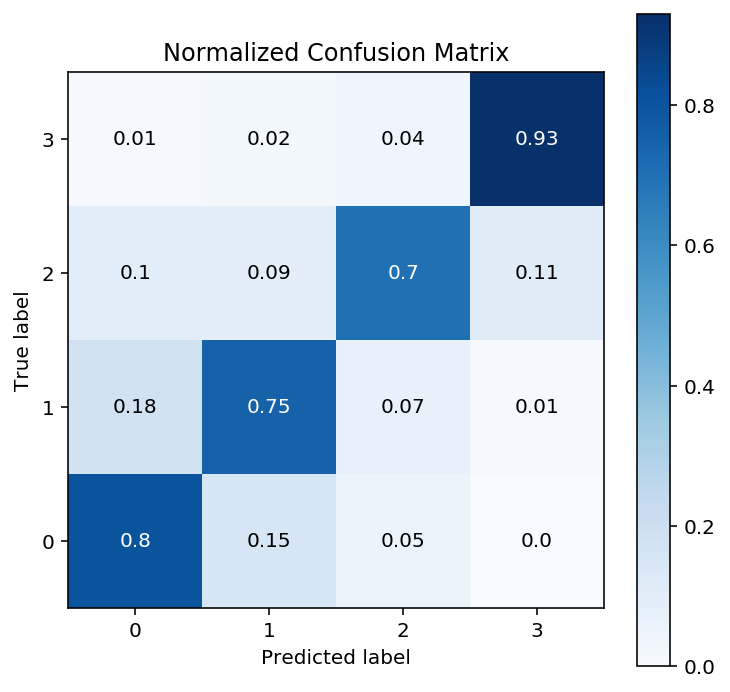

In [352]:
for i, clf in enumerate(top_clf.Params):
    clf.fit(train_clX, yc_train)
    pred_test = clf.predict(test_clX)
    pred_train = clf.predict(train_clX)

    confusion = skplt.metrics.plot_confusion_matrix(yc_train, pred_train, figsize = (6,6), normalize=True)
    
    try:
        probs = clf.predict_proba(test_X)[:, 1]
    except:
        pass

    print("{}'s Classification Report: \n".format(top_clf.index[i]), classification_report(yc_test, pred_test, digits=4 ))
    print("{}'s Confusion Matrix: \n".format(top_clf.index[i]), confusion)
    plt.ylim([-0.5, len(yc_train.unique())-0.5])
    plt.show()
    
fig.savefig('ConfusionMatrices.pdf', bbox_inches='tight')

## Figuring Feature Importance in Logistic Regression:  (do other 2 models return coefs?)

In [354]:
top_clf.Params

RandomForest    (DecisionTreeClassifier(class_weight=None, cri...
LogReg          LogisticRegression(C=0.0002682695795279727, cl...
SVC             SVC(C=1.0, cache_size=200, class_weight=None, ...
Name: Params, dtype: object

In [297]:
top_clf.Params[1].coef_.shape

(4, 583)

Though the best model here is RF, I nonetheless am keen to visualize Logistic Regression's coefficients' feature importance for each of its 4 classes. Cf README for analysis.

'All_features' returned from section 1.3: 

In [353]:
all_features = list(hot_features) + list(cl_nlpfeatures) + numeric_features

In [309]:
len(all_features)

590

                                                 coef  abs_coef
x7_NatSavs_same                             -0.124530  0.124530
activities                                  -0.073248  0.073248
aggregated activities                       -0.065773  0.065773
aggregated                                  -0.062278  0.062278
x4_Other Official Flows (non Export Credit) -0.060405  0.060405
x0_Chile                                    -0.060084  0.060084
x4_Credit line                              -0.059298  0.059298
x2_IADB                                     -0.058164  0.058164
apl                                         -0.055609  0.055609
access                                      -0.051800  0.051800
AdjSav_CO2dmg_usd                           -0.050998  0.050998
x7_NatSavs_slowed                           -0.050043  0.050043
africa                                      -0.046282  0.046282
diversos proyectos                           0.045222  0.045222
diversos                                

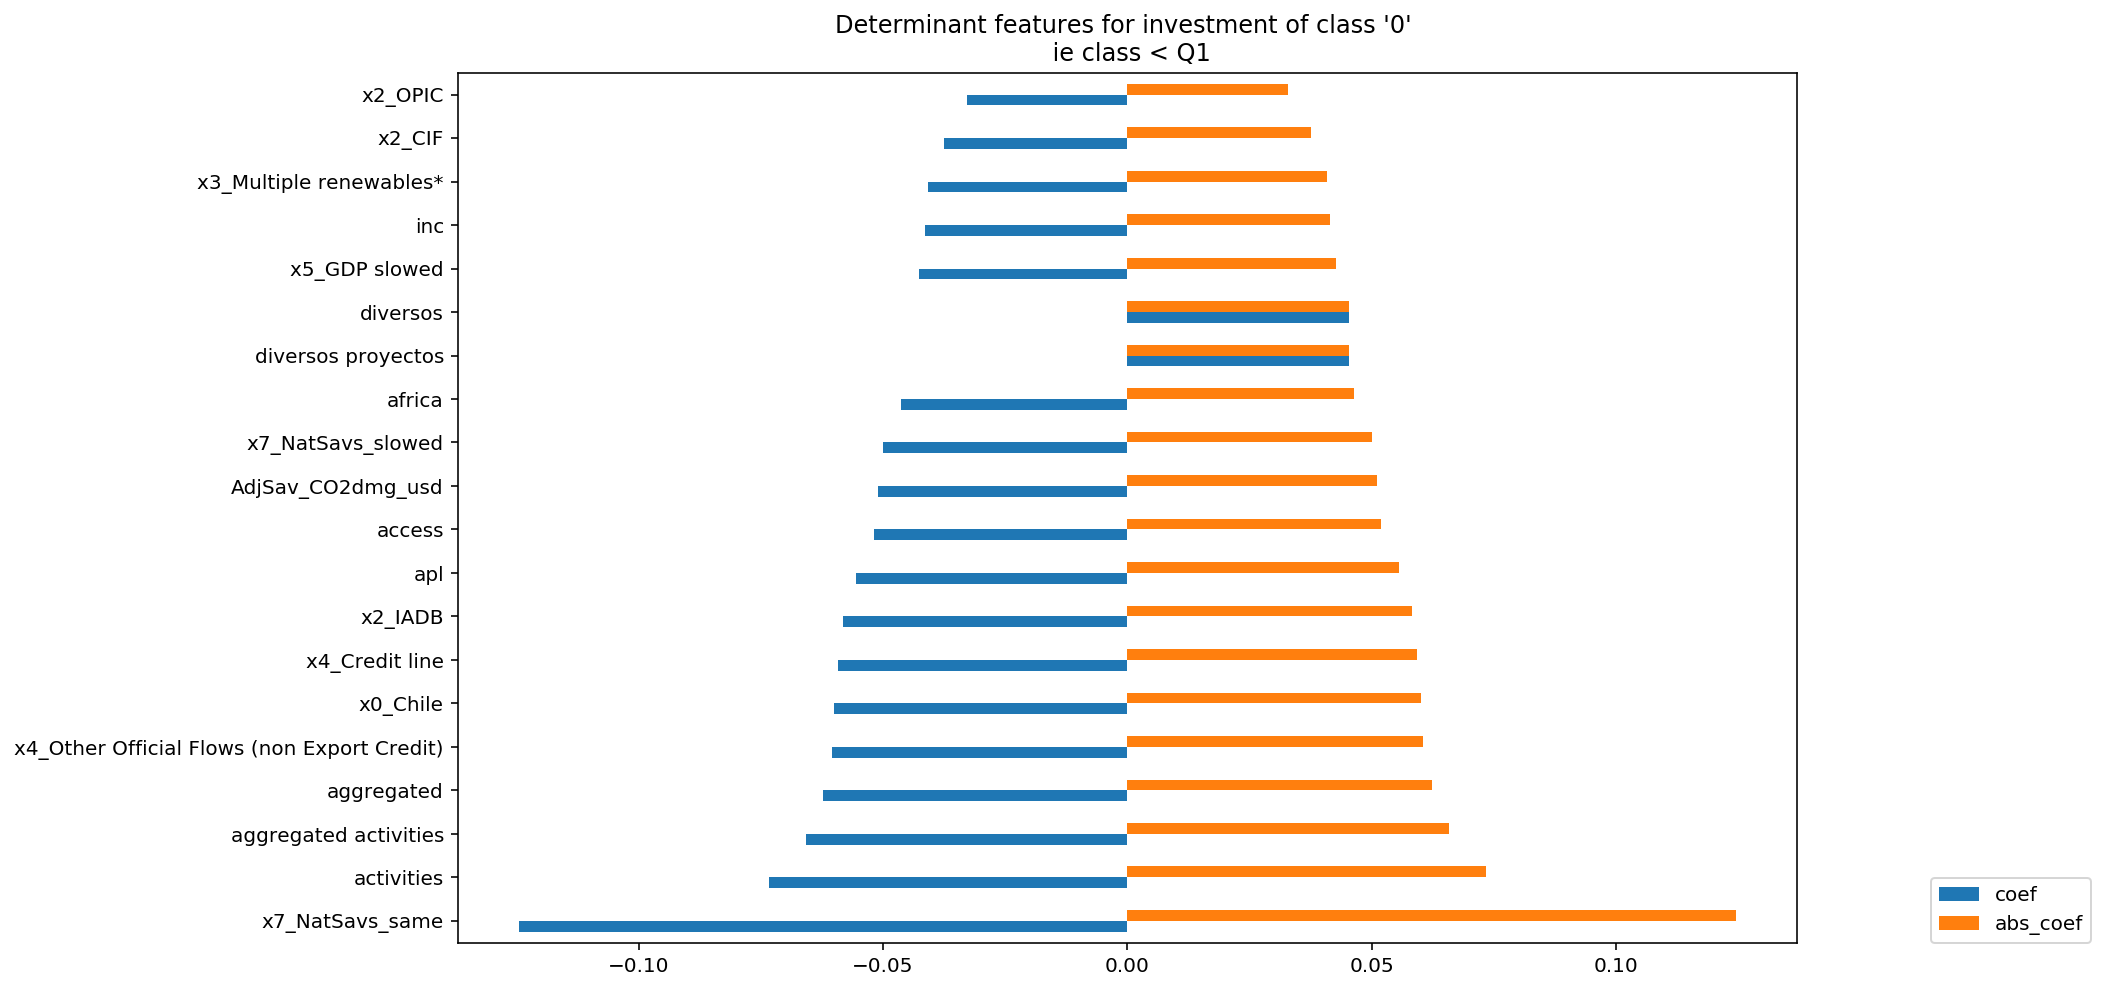

In [357]:
fi_0 = pd.DataFrame(list(zip(top_clf.Params[1].coef_[0],
                      abs(top_clf.Params[1].coef_[0]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(fi_0))

fi_0.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '0' \n ie class < Q1");
plt.legend(loc=[1.1,0])

fig.savefig('LR_fic0.pdf', bbox_inches='tight')

                                                 coef  abs_coef
x7_NatSavs_same                             -0.128362  0.128362
aggregated activities                       -0.076218  0.076218
activities                                  -0.070413  0.070413
aggregated                                  -0.061515  0.061515
x2_IADB                                     -0.060211  0.060211
x4_Credit line                              -0.059434  0.059434
access                                      -0.055011  0.055011
x7_NatSavs_slowed                           -0.053553  0.053553
x5_GDP slowed                               -0.051649  0.051649
africa                                      -0.049651  0.049651
x0_Chile                                    -0.049573  0.049573
apl                                         -0.045187  0.045187
x4_Other Official Flows (non Export Credit) -0.044704  0.044704
x3_Multiple renewables*                     -0.041450  0.041450
AdjSav_CO2dmg_usd                       

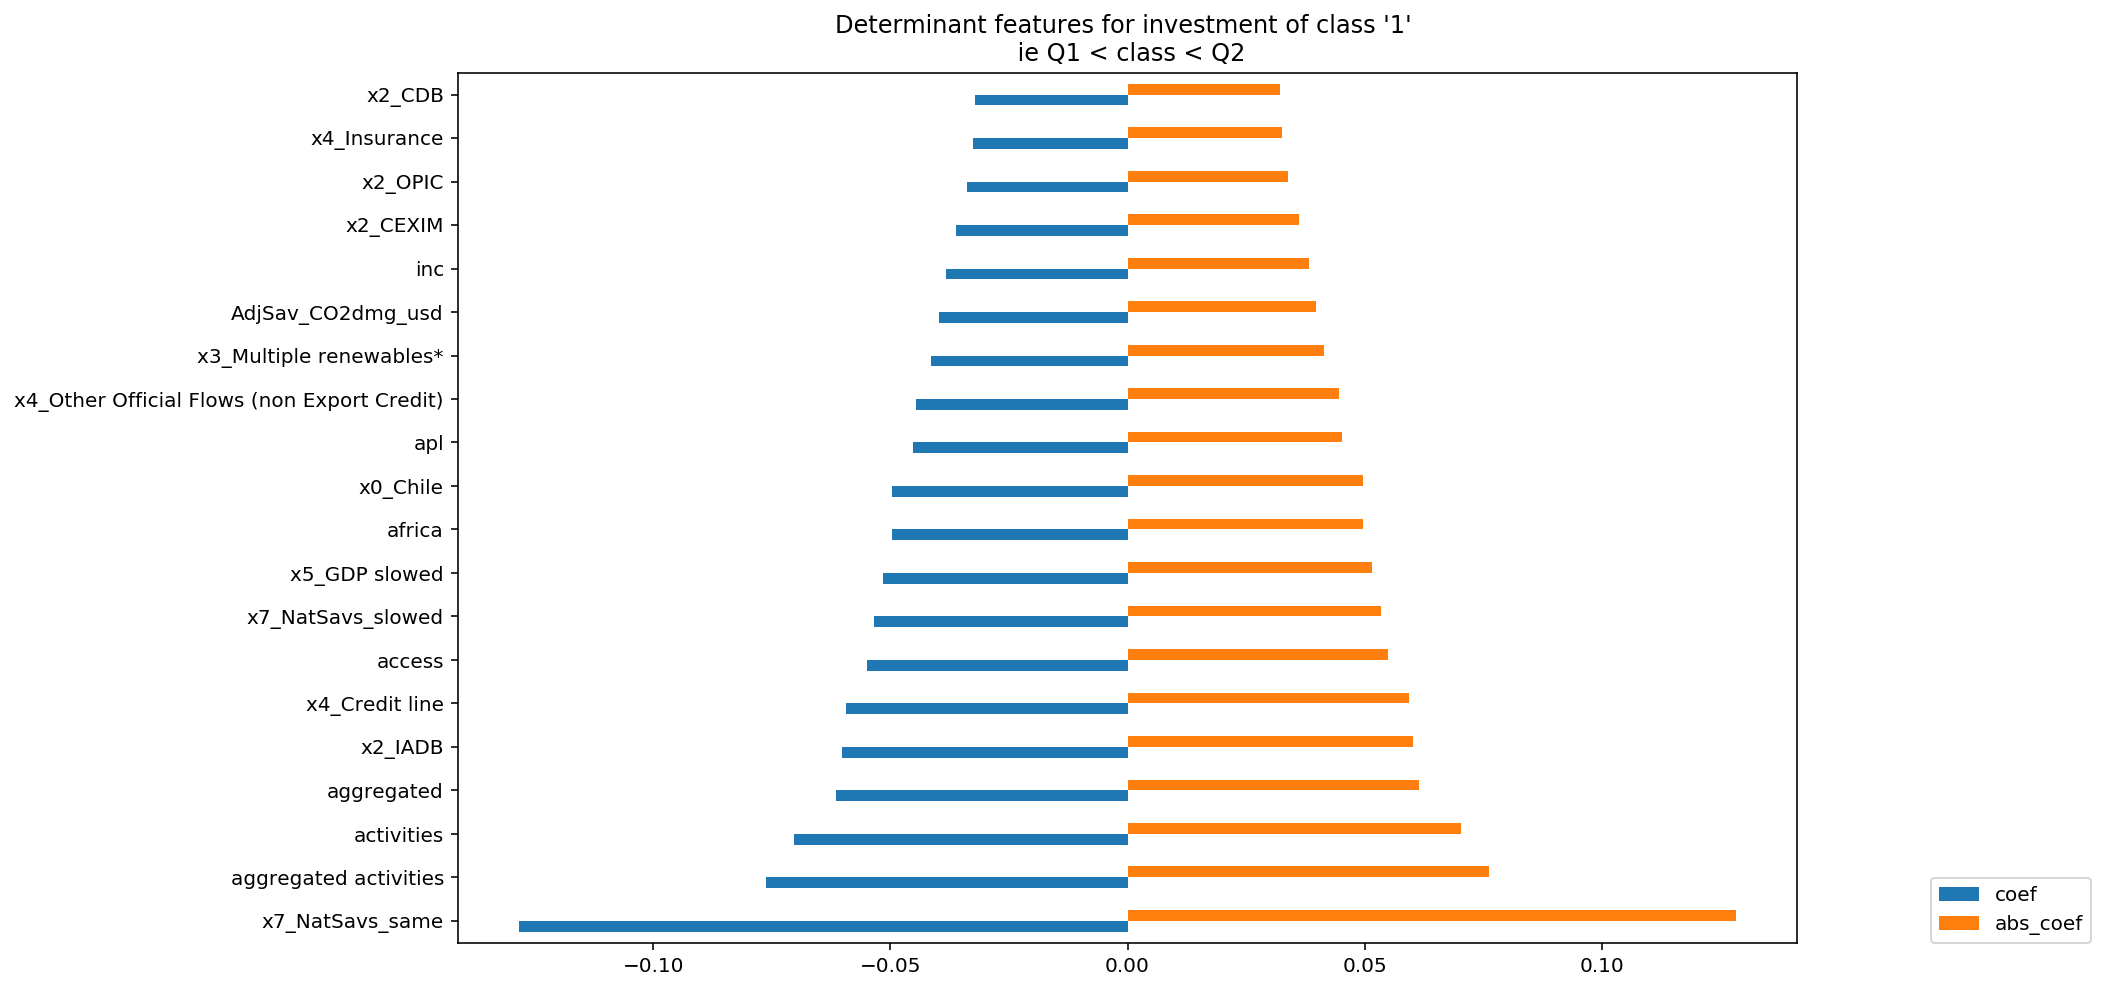

In [358]:
fi_1 = pd.DataFrame(list(zip(top_clf.Params[1].coef_[1],
                      abs(top_clf.Params[1].coef_[1]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(pd.DataFrame(fi_1))

fi_1.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '1' \n ie Q1 < class < Q2");
plt.legend(loc=[1.1,0])
fig.savefig('LR_fic1.pdf', bbox_inches='tight')

                           coef  abs_coef
access                -0.067954  0.067954
x6_gni_same           -0.063678  0.063678
aggregated activities -0.061814  0.061814
x7_NatSavs_same       -0.059117  0.059117
africa                -0.056671  0.056671
aggregated            -0.055394  0.055394
x3_Solar energy       -0.049295  0.049295
apl                   -0.044997  0.044997
activities            -0.044491  0.044491
x3_Wind energy        -0.040462  0.040462
x5_GDP slowed         -0.039570  0.039570
AdjSav_CO2dmg_usd     -0.036990  0.036990
flow                   0.035303  0.035303
x2_IADB               -0.034044  0.034044
x4_Insurance          -0.031504  0.031504
x4_Credit line         0.030532  0.030532
x2_OPIC               -0.030044  0.030044
x0_Chile              -0.028672  0.028672
x3_Geothermal energy  -0.028510  0.028510
installation solar     0.028303  0.028303


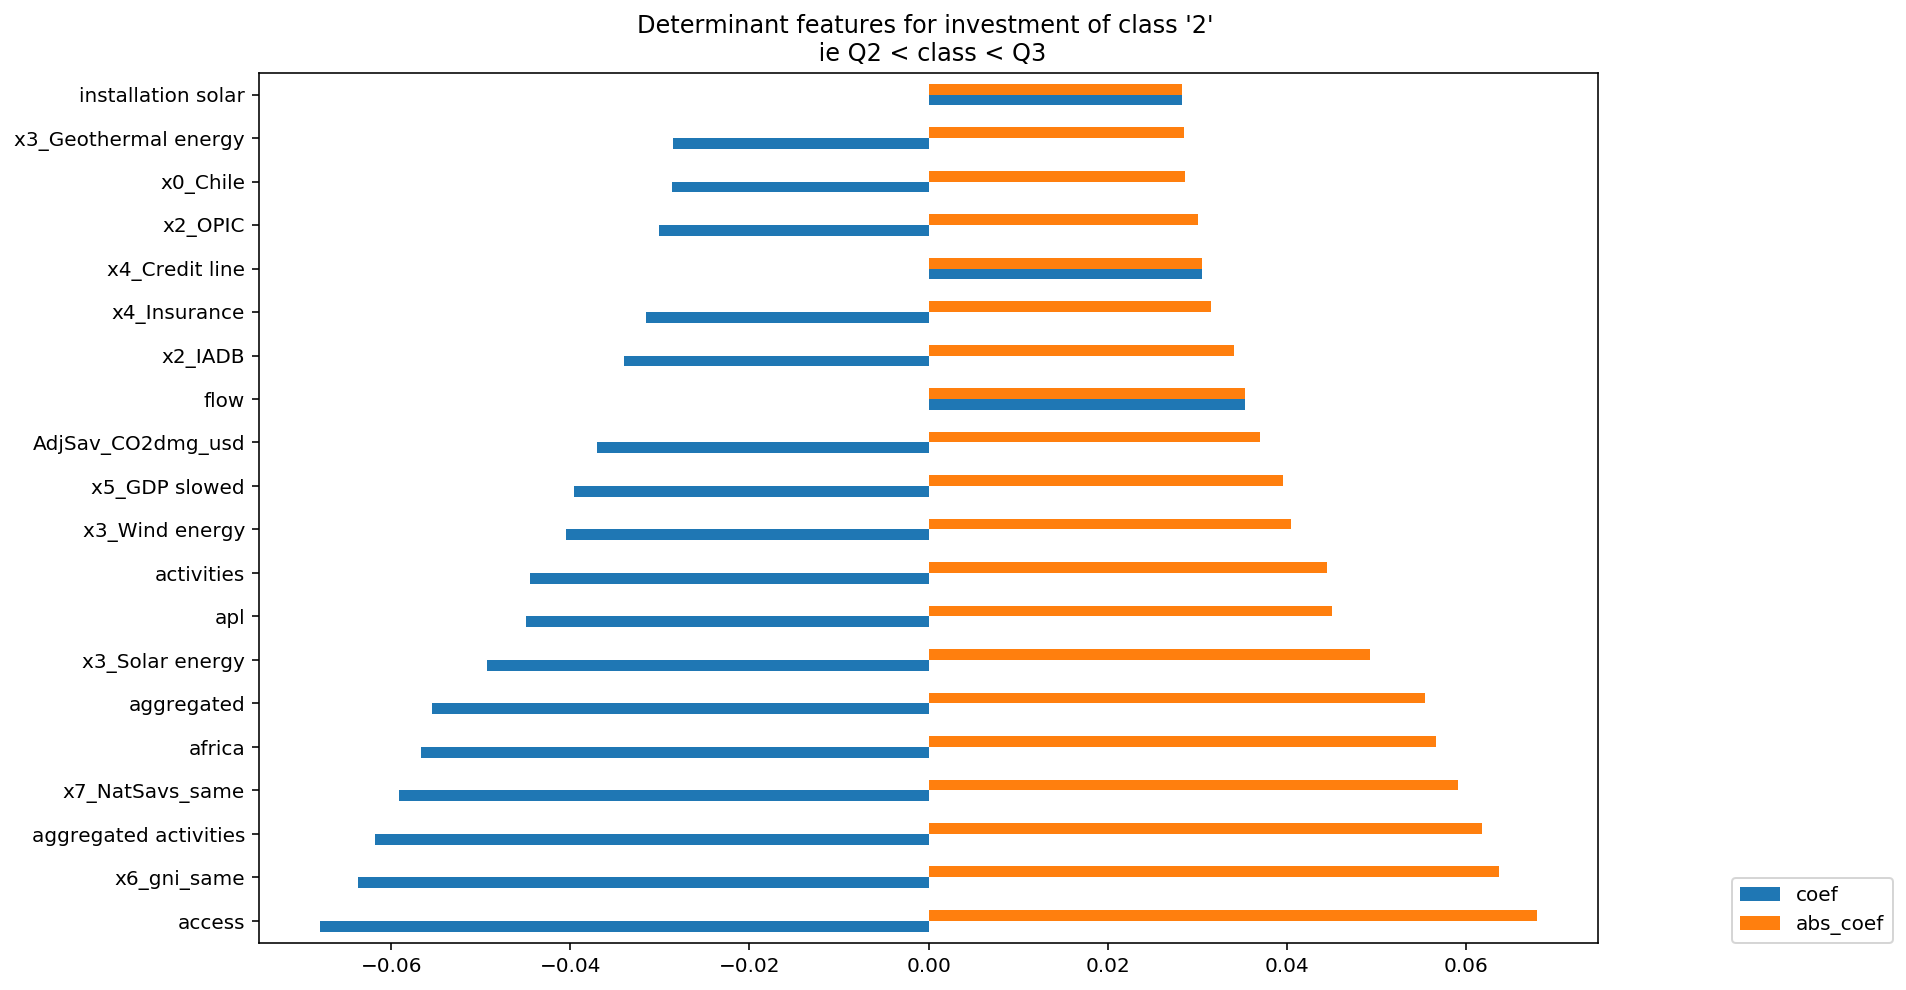

In [359]:
fi_2 = pd.DataFrame(list(zip(top_clf.Params[1].coef_[2],
                      abs(top_clf.Params[1].coef_[2]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(fi_2)
fi_2.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '2' \n ie Q2 < class < Q3");
plt.legend(loc=[1.1,0])
fig.savefig('LR_fic2.pdf', bbox_inches='tight')

                           coef  abs_coef
x6_gni_same           -0.250874  0.250874
x3_Solar energy       -0.183452  0.183452
x7_NatSavs_same        0.139972  0.139972
x4_Insurance          -0.075974  0.075974
x2_IADB                0.061002  0.061002
x7_NatSavs_slowed      0.059258  0.059258
access                -0.049218  0.049218
aggregated activities -0.047658  0.047658
x2_OPIC                0.046710  0.046710
area                  -0.046136  0.046136
x5_GDP grew           -0.046095  0.046095
assistance            -0.046055  0.046055
bagasse               -0.044809  0.044809
x3_Geothermal energy  -0.044638  0.044638
x0_Chile               0.044396  0.044396
AdjSav_CO2dmg_usd      0.043162  0.043162
africa                -0.040505  0.040505
x2_KEXIM               0.039750  0.039750
activities            -0.038958  0.038958
x5_GDP slowed          0.037331  0.037331


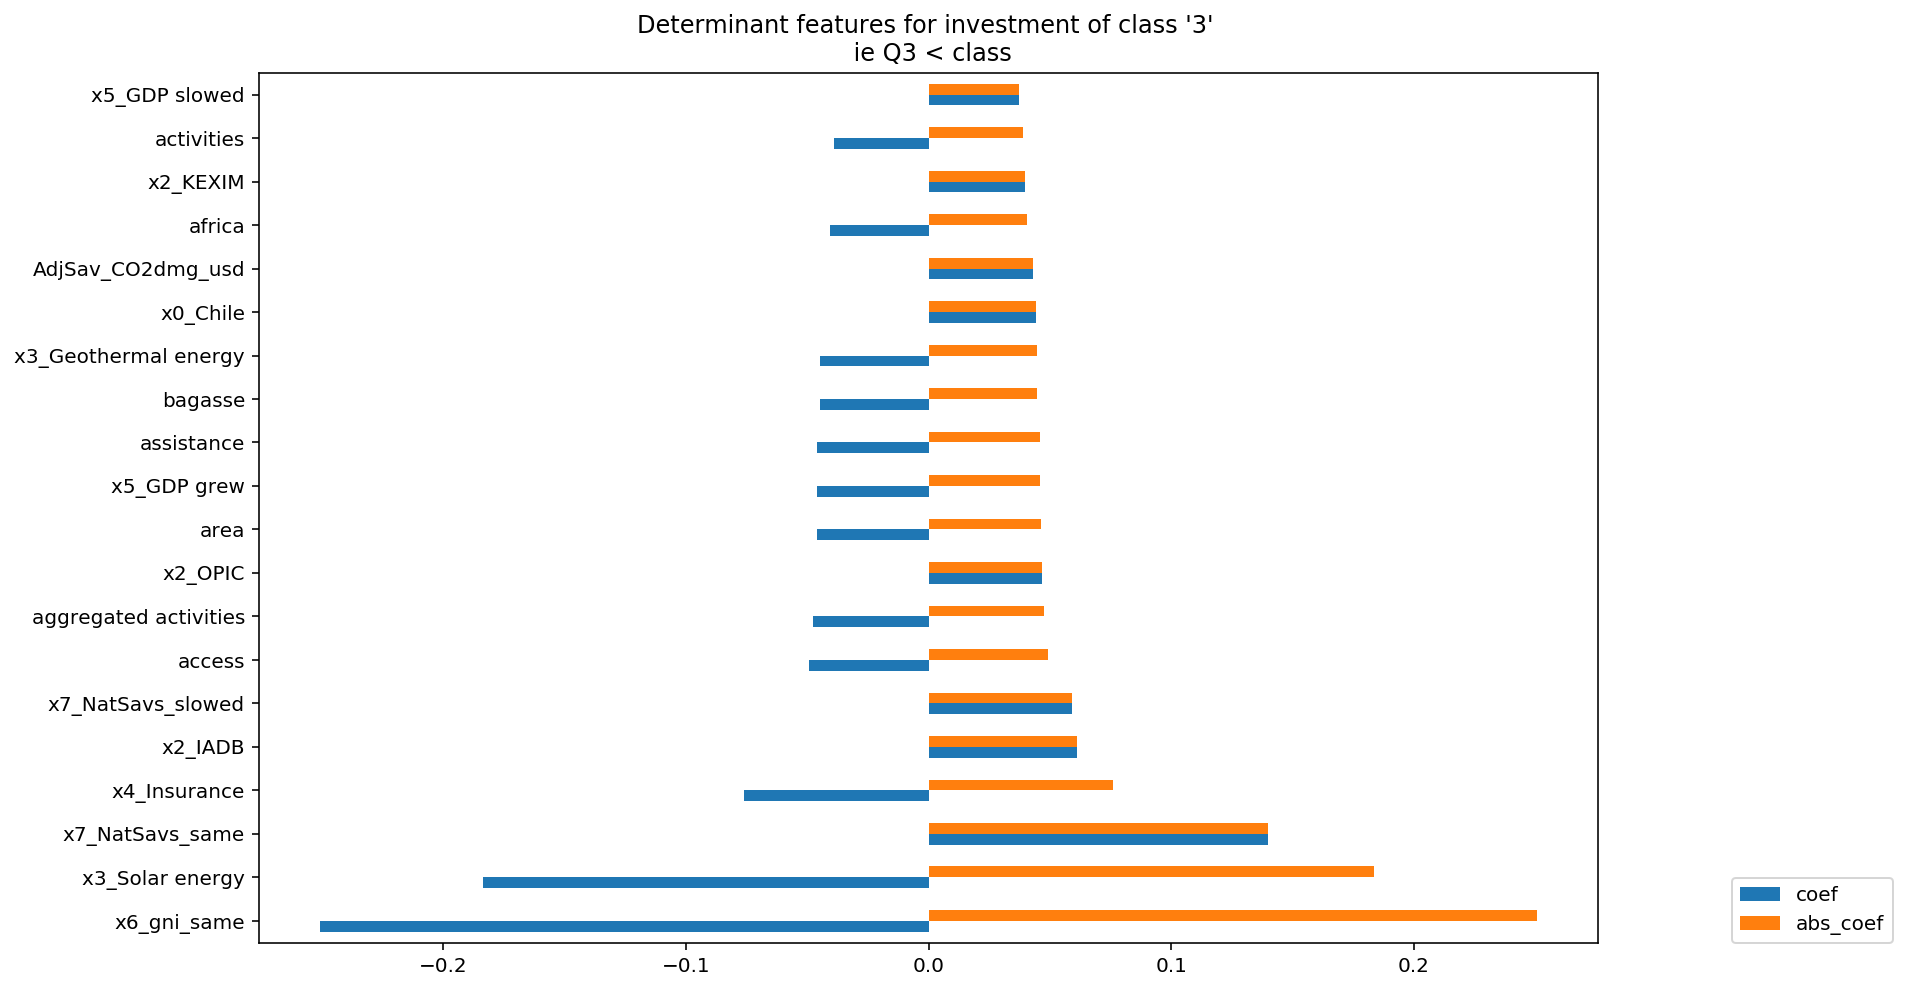

In [360]:
fi_3 = pd.DataFrame(list(zip(top_clf.Params[1].coef_[3],
                      abs(top_clf.Params[1].coef_[3]))),
             columns=['coef', 'abs_coef'], index = all_features).sort_values(
        by='abs_coef', ascending = False)[:20]
print(fi_3)
fi_3.plot(kind = 'barh', figsize = (12, 8), title = "Determinant features for investment of class '3' \n ie Q3 < class");
plt.legend(loc=[1.1,0])

fig.savefig('LR_fic3.pdf', bbox_inches='tight')

For a reflection on SVC's results, cf both Modelling, trial 1 notebook or/and the ReadMe

In [363]:
top_clf.Params[2]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=1)

## Plotting revelatory curves: ROC & Precision-Recall 

Below I plot the top 3 classifiers' revelatory curves to visualize how their performance over different classifying threshold levels. Cf README for analysis

In [365]:
top_clf.Params[0].predict_proba(test_clX)

array([[0.26978714, 0.2815586 , 0.26103214, 0.18762212],
       [0.24183549, 0.28224127, 0.28805332, 0.18786992],
       [0.34597801, 0.26272124, 0.24811322, 0.14318752],
       ...,
       [0.27018704, 0.30693973, 0.27380234, 0.14907089],
       [0.30228577, 0.32263334, 0.23063994, 0.14444094],
       [0.35799501, 0.26561578, 0.24150103, 0.13488818]])

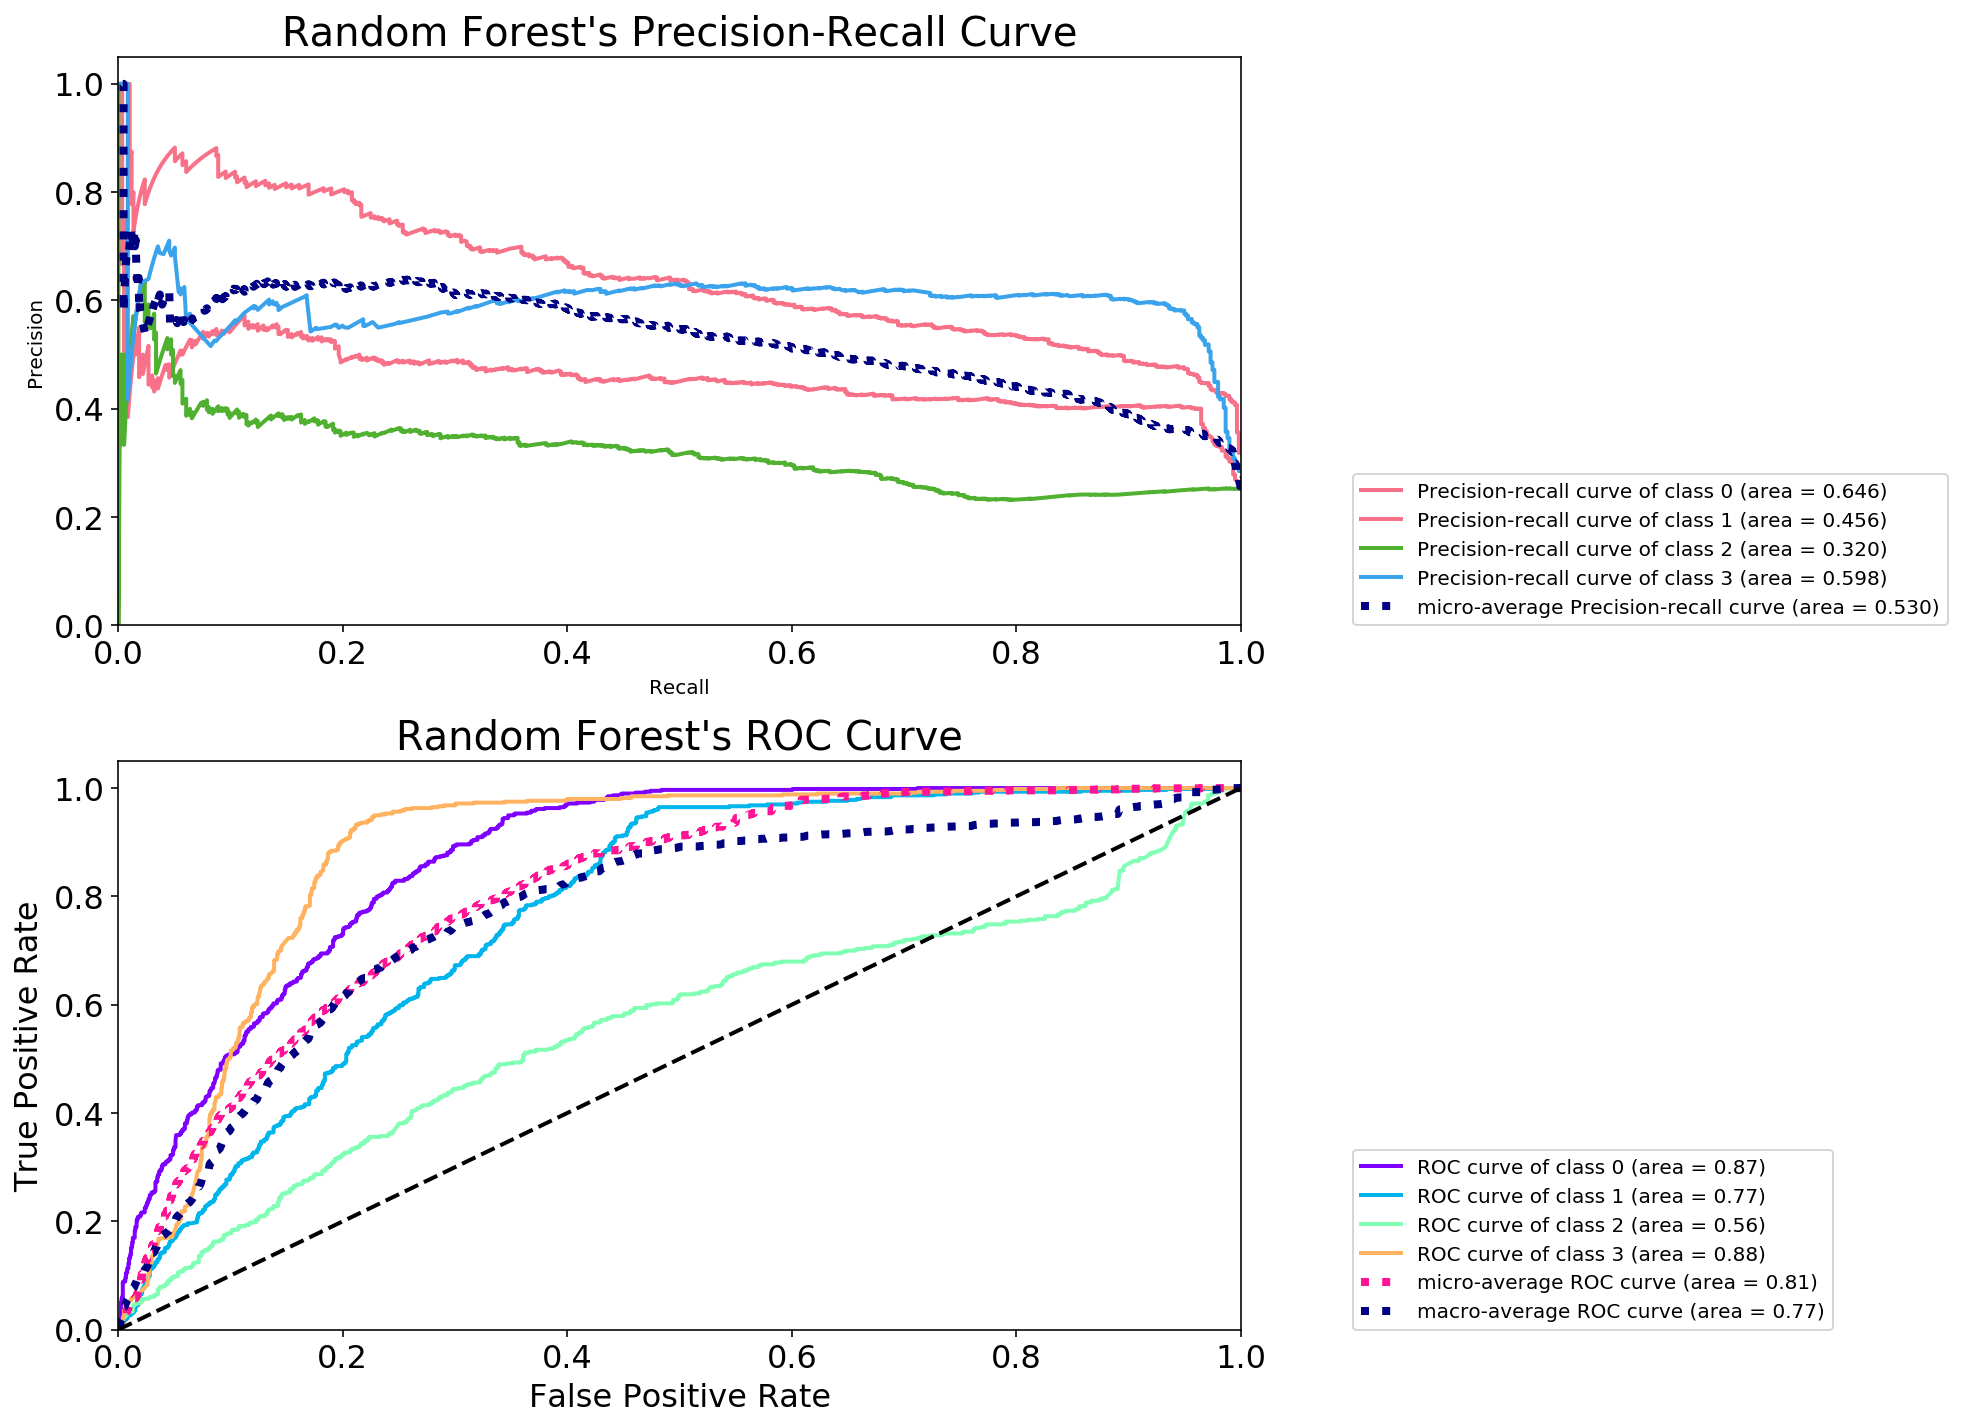

In [366]:
fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[0].predict_proba(test_clX), 
                       plot_micro=True, title = "Random Forest's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[0].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "Random Forest's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

#fig.suptitle("Logistic Regression's alternative scoring: \n", fontsize = 16)

plt.tight_layout()
plt.show()

fig.savefig('LR_PRROC.pdf', bbox_inches='tight')

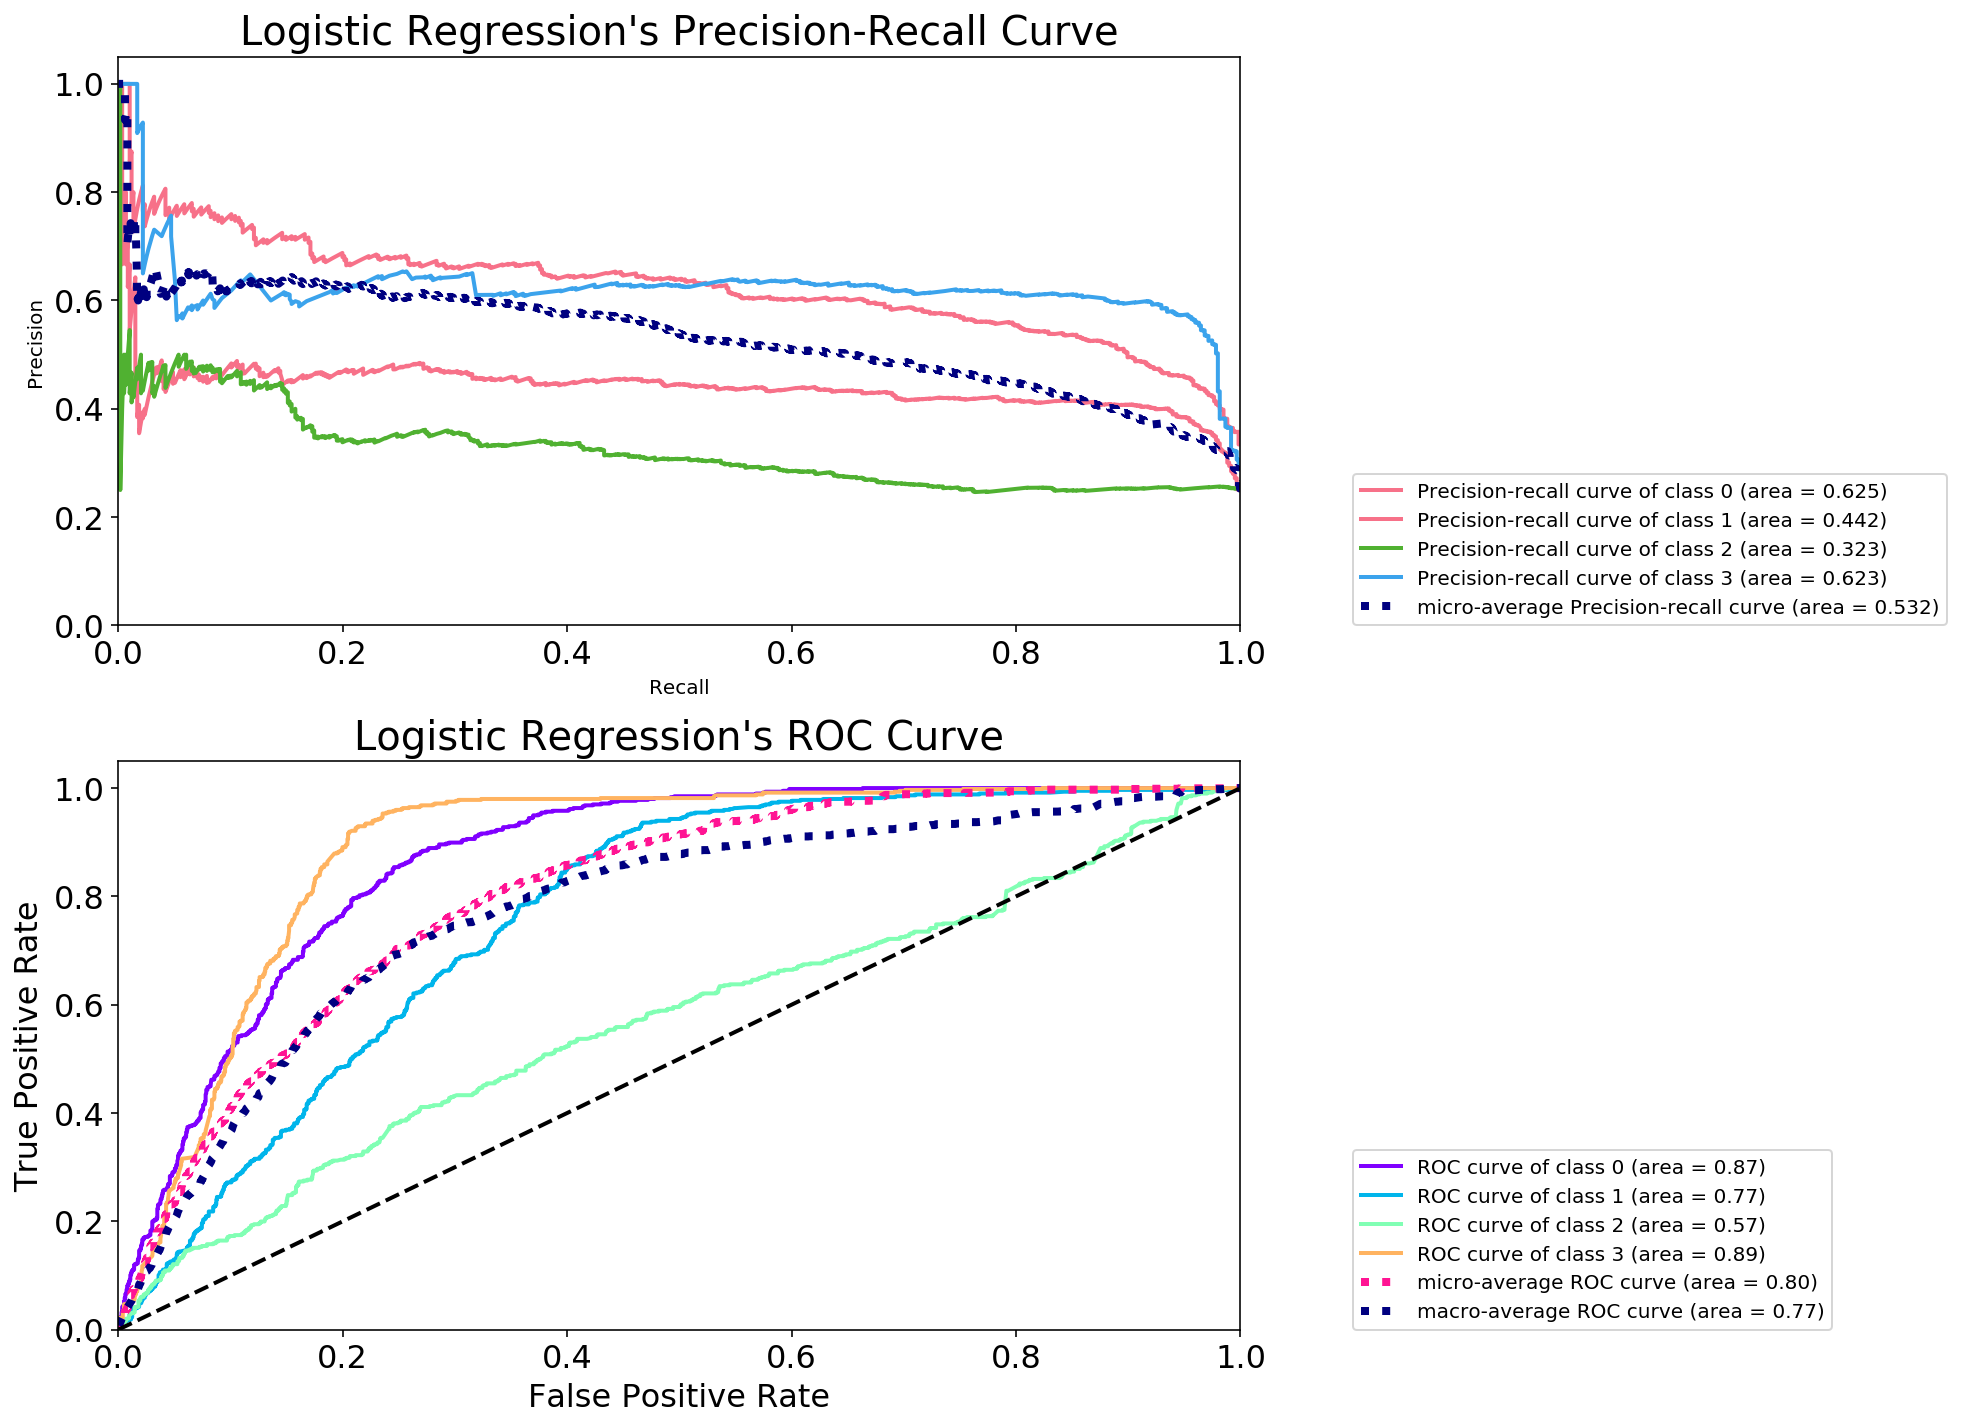

In [367]:
fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[1].predict_proba(test_clX), 
                       plot_micro=True, title = "Logistic Regression's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[1].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "Logistic Regression's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

plt.tight_layout()
plt.show()

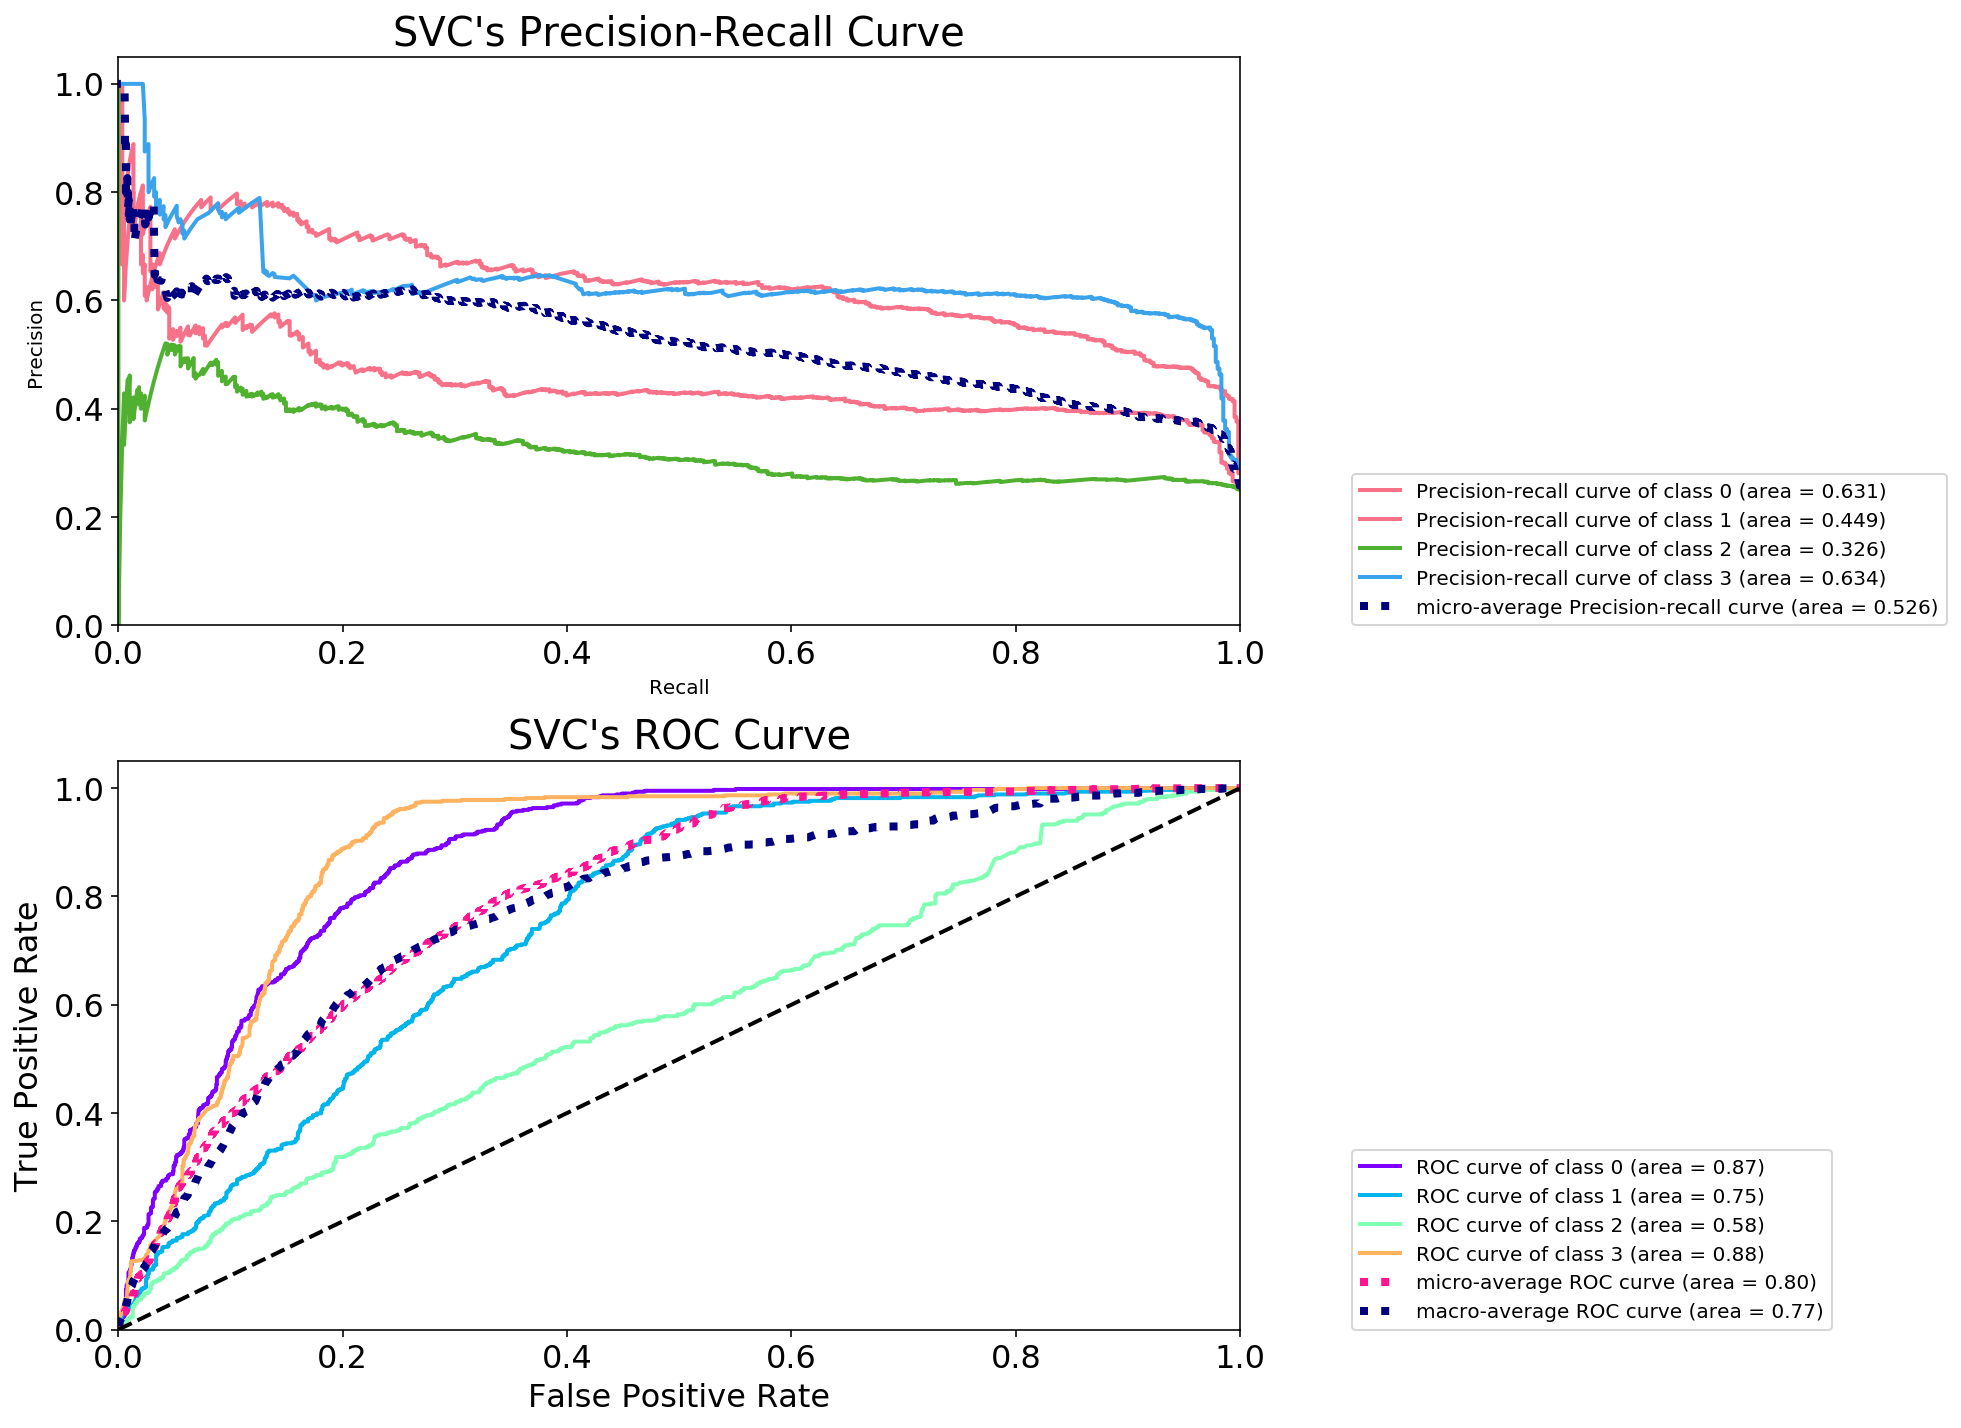

In [368]:
#Had to rerun SVC with proba = True in very above to run this:


fig, ax = plt.subplots(2, 1, figsize = (14, 10))

skplt.metrics.plot_precision_recall(yc_test, top_clf.Params[2].predict_proba(test_clX), 
                       plot_micro=True, title = "SVC's Precision-Recall Curve",
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax[0])
ax[0].legend(loc=[1.1, 0])


skplt.metrics.plot_roc(yc_test, top_clf.Params[2].predict_proba(test_clX), plot_micro=True, plot_macro=True,
                       title = "SVC's ROC Curve",
    title_fontsize=20, text_fontsize=16, cmap= 'rainbow', ax = ax[1])

ax[1].legend(loc=[1.1,0])

plt.tight_layout()
plt.show()

## Frosting features: engineering of section above 'add_df2' namely GDP, GNI & Adjusted Net National Savings' fluctuation over a year:

Though this code is originally run in notebook "Modelling, trial 1" - section 2.4, it is reproduced below for intelligibility: 

In [ ]:
X.groupby(['Country', 'Date'])['gdp_g_anpc'].sum()

In [ ]:
X3 = X.copy()

In [ ]:
X3.Date = pd.to_datetime(X3.Date)

In [ ]:
gdp_shift = pd.Series(X4.groupby(['Country','Date'])['gdp_g_anpc'].unique().shift())
gdp_df = pd.DataFrame(gdp_shift) 
gdp_dir = []
for x in range(len(gdp_df.gdp_g_anpc)):
    if gdp_df.gdp_g_anpc[x] > gdp_df.gdp_g_anpc[x-1]:
        gdp_dir.append("GDP grew")
    elif gdp_df.gdp_g_anpc[x] < gdp_df.gdp_g_anpc[x-1]:
        gdp_dir.append("GDP slowed")
    else: 
        gdp_dir.append("Same GDP")
gdp_df['gdp_fluc'] = gdp_dir
gdp_df.reset_index(inplace=True)

In [ ]:
X4.groupby(['Country', 'Date'])['gni_g_anpc'].unique()
gni_shift = pd.Series(X4.groupby(['Country','Date'])['gni_g_anpc'].unique().shift())
gni_df = pd.DataFrame(gni_shift)
gni_dir = []
for x in range(len(gni_df.gni_g_anpc)):
    if gni_df.gni_g_anpc[x] > gni_df.gni_g_anpc[x-1]:
        gni_dir.append("gni_grew")
    elif gni_df.gni_g_anpc[x] < gni_df.gni_g_anpc[x-1]:
        gni_dir.append("gni_slowed")
    else: 
        gni_dir.append("gni_same")
        
gni_df['gni_fluc'] = gni_dir

gni_df.reset_index(inplace=True)
gni_df

In [ ]:
NS_df = pd.DataFrame(pd.Series(X4.groupby(['Country','Date'])['AdjNetNatSv_usd'].unique().shift()))
ns_dir = []
for x in range(len(NS_df.AdjNetNatSv_usd)):
    if NS_df.AdjNetNatSv_usd[x] > NS_df.AdjNetNatSv_usd[x-1]:
        ns_dir.append("NatSavs_grew")
    elif NS_df.AdjNetNatSv_usd[x] < NS_df.AdjNetNatSv_usd[x-1]:
        ns_dir.append("NatSavs_slowed")
    else: 
        ns_dir.append("NatSavs_same")
        
NS_df['NS_fluc'] = ns_dir
NS_df.reset_index(inplace=True)


In [ ]:
add_fts = gdp_df.merge(gni_df, on = ['Country', 'Date'], how = 'left')
add_fts = add_fts.merge(NS_df, on = ['Country', 'Date'], how = 'left')
add_fts.drop(['gdp_g_anpc', 'gni_g_anpc', 'AdjNetNatSv_usd', 'index'], axis=1, inplace=True)
add_fts.to_csv('Engy_addfts.csv', index=False)

## Next steps reference NLP code:  

O'Reilly's awesome text lemmatizer, referenced in ReadMe's Next Steps: 

In [48]:
import unicodedata
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
    
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document)